In [2]:
import numpy as np
from scipy.stats import norm
import copy
import matplotlib.pyplot as plt
from __future__ import division

In [42]:
class agent_based_model:
    
    """set the model as object"""
    
    # constructor
    def __init__(self, v=1 , N_regions=42, dt=0.01, sconn_len=None, sconn_den=None, snca=None, gba=None, roi_size=None, fconn=None, fcscale=None):
        
        # number of regions
        self.N_regions = N_regions
        
        # store number of normal and misfolded proteins in regions
        self.nor = np.zeros((N_regions,), dtype = np.int)
        self.nor_history = np.empty((0, N_regions), dtype = np.int)
        self.mis = np.zeros((N_regions,), dtype = np.int)
        self.mis_history = np.empty((0, N_regions), dtype = np.int)
        
        
        # store number of normal and misfolded proteins in paths
        self.sconn_len = np.int_(np.round(sconn_len / v))
        (self.idx_x, self.idx_y) = np.nonzero(self.sconn_len)
        self.non_zero_lengths = self.sconn_len[self.idx_x, self.idx_y]  # int64
        self.path_nor, self.path_mis = [ [ [[] for y in range(N_regions)] for x in range(N_regions)] ] * 2
        
        #### is there more efficient way to do this?  --- to be updated.......
        for x, y, v in zip(self.idx_x, self.idx_y, self.non_zero_lengths):
            self.path_nor[x][y], self.path_mis[x][y] = [ [0 for k in range(v)] ] * 2
            
        # record the trajectory
        self.path_nor_history = []
        self.path_mis_history = []
        
        # continuous path and path history
        self.path_nor_cont, self.path_mis_cont = [np.zeros((N_regions, N_regions), dtype = np.int)] * 2
        self.path_nor_cont_history, self.path_mis_cont_history = [np.empty((0, self.N_regions, self.N_regions))] * 2
        
        # time step
        self.dt = dt
        
        # synthesis rate and clearance rate
        self.synthesis_rate = norm.cdf(snca) * self.dt
        self.clearance_rate = 1 - np.exp(-norm.cdf(gba) * self.dt)       
        
        # probability of exit a path is set to v/sconn_len
        sconn_len[sconn_len ==0] = np.inf
        self.prob_exit = self.dt * v / sconn_len
        self.prob_exit[sconn_len==0] = 0 # remove NaNs....
        
        # travel weights
        self.weights = np.exp(fcscale * fconn) * sconn_den
        
        self.weights = np.sum(self.weights, axis = 1) * np.eye(self.N_regions) + self.weights
        
        # scale 
        self.weights = self.weights / np.sum(self.weights, axis = 1).reshape(self.N_regions, 1)
        
        # region size
        self.roi_size = roi_size.flatten()
        
        self.synthesis_control = np.int_(roi_size.flatten())
        
                
    def normal_alpha_syn_growth_region(self):
        """step: normal alpha-syn synthesized and cleared in regions"""

        self.nor -= np.array([np.sum(np.random.uniform(0, 1, (v, )) < k) 
                             for k, v in zip(self.clearance_rate, self.nor)])
        
        
        ## synthesis
        self.nor += np.array([np.sum(np.random.uniform(0, 1, (v, )) < k) 
                              for k, v in zip(self.synthesis_rate, self.synthesis_control) ])
                              # or self.roi_size)])
    
    def normal_alpha_syn_growth_edge_discrete(self):
        """proteins are moving discretely in edges"""
        # alpha syn  -- from region to path
        # exit region
        exit_process = np.array([ np.random.multinomial(self.nor[k], self.weights[k]) 
                                 for k in range(self.N_regions)], dtype = np.int)
        
        # alpha syn -- from path to region
        # enter region
        enter_process = np.zeros((self.N_regions, self.N_regions), dtype=np.int)
        
        for x, y in zip(self.idx_x, self.idx_y):
            # fetch then remove the last element
            enter_process[x, y] = self.path_nor[x][y].pop()
            # update paths
            self.path_nor[x][y].insert(0, exit_process[x, y])

        # update regions 
        self.nor = exit_process[np.nonzero(np.eye(self.N_regions))] + np.sum(enter_process, axis = 0)
        
    def normal_alpha_syn_growth_edge_continuous(self):
        """proteins are moving contiously in edges"""
        
        # exit regions:
        exit_process = np.array([ np.random.multinomial(self.nor[k], self.weights[k]*self.dt) 
                                 for k in range(self.N_regions)], dtype = np.int)
        exit_process[np.eye(self.N_regions)==1] = 0 # remove diagonal
        
        # enter regions:
        enter_process = np.zeros((self.N_regions, self.N_regions), dtype = np.int)
        
        for x, y in zip(self.idx_x, self.idx_y):
            enter_process[x, y] = np.sum(np.random.uniform(0, 1, (self.path_nor_cont[x, y], )) < self.prob_exit[x, y])
        
        # update:
        self.path_nor_cont += (exit_process - enter_process)
        self.path_nor_cont[np.eye(self.N_regions)==1] == 0
        self.path_nor = exit_process[np.nonzero(np.eye(self.N_regions))] + np.sum(enter_process, axis = 0)
        
        
    def inject_mis(self, seed=42, initial_number=1):
        
        """inject initual_number misfolded protein into seed region"""
        # initial_number must be an interger
        self.mis[seed] = initial_number
        #print('inject %d misfolded alpha-syn into region %d' % (initial_number, seed))
        
    
    def misfolded_alpha_syn_spread_edge_discrete(self):
        """ step in paths for normal and misfolded alpha syn"""
        
        ############## misfolded alpha synuclein ###########
        # exit regions
        exit_process = np.array([ np.random.multinomial(v, self.weights[k]) 
                                 for k, v in enumerate(self.mis)], dtype = np.int)
        # alpha syn -- from path to region
        # enter region
        enter_process = np.zeros((self.N_regions, self.N_regions), dtype = np.int)
        for x, y in zip(self.idx_x, self.idx_y):
            # fetch then remove the last element
            enter_process[x, y] = self.path_mis[x][y].pop()
            # update paths
            self.path_mis[x][y].insert(0, exit_process[x, y])

        # update regions 
        self.mis = exit_process[np.nonzero(np.eye(self.N_regions))] + np.sum(enter_process, axis = 0)
        
        ########### for the normal alpha syuclein ###########
        exit_process = np.array([ np.random.multinomial(self.nor[k], self.weights[k]) 
                                 for k in range(self.N_regions)], dtype = np.int)
        
        # alpha syn -- from path to region
        # enter region
        enter_process = np.zeros((self.N_regions, self.N_regions), dtype=np.int)
        
        for x, y in zip(self.idx_x, self.idx_y):
            # fetch then remove the last element
            enter_process[x, y] = self.path_nor[x][y].pop()
            # update paths
            self.path_nor[x][y].insert(0, exit_process[x, y])

        # update regions 
        self.nor = exit_process[np.nonzero(np.eye(self.N_regions))] + np.sum(enter_process, axis = 0)
        
    def misfolded_alpha_syn_spread_edge_continous(self):
        """proteins are moving continously"""
        ##### misfolded alpha synuclein #####
        exit_process = np.array([ np.random.multinomial(v, self.weights[k]) 
                                 for k, v in enumerate(self.mis)], dtype = np.int)
        
        enter_process = np.zeros((self.N_regions, self.N_regions), dtype = np.int)
        
        # enter regions:
        for x, y in zip(self.idx_x, self.idx_y):
            enter_process[x, y] = np.sum(np.random.uniform(0, 1, (self.path_mis_cont[x, y], )
                                                          ))< self.prob_exit[x, y]
        
        # update
        self.path_mis_cont += (exit_process - enter_process)
        self.path_mis_cont[np.eye(self.N_regions)==1] == 0
        self.mis = np.sum(enter_process, axis = 0) + exit_process[np.nonzero(np.eye(self.N_regions))]
        
        ####### normal alpha synuclein #######
        # exit regions:
        exit_process = np.array([ np.random.multinomial(self.nor[k], self.weights[k]) 
                                 for k in range(self.N_regions)], dtype = np.int)
        
        # enter regions:

        enter_process = np.zeros((self.N_regions, self.N_regions), dtype = np.int)
        
        for x, y in zip(self.idx_x, self.idx_y):
            enter_process[x, y] = np.sum(np.random.uniform(0, 1, (self.path_nor_cont[x, y], ) 
                                                          ) )< self.prob_exit[x, y]
        
        # update:
        self.path_nor_cont += (exit_process - enter_process)
        self.path_nor_cont[np.eye(self.N_regions)==1] == 0
        self.path_nor = exit_process[np.nonzero(np.eye(self.N_regions))] + np.sum(enter_process, axis = 0)
        
    def misfolded_alpha_syn_spread_region(self, trans_rate=1):
        """clearance and synthesis of normal/misfolded alpha-syn/ transsmssion process in regions"""
        ## clearance
        cleared_nor = np.array([np.sum(np.random.uniform(0, 1, (v, )) < k) 
                             for k, v in zip(self.clearance_rate, self.nor)])
        
        cleared_mis = np.array([np.sum(np.random.uniform(0, 1, (v, )) < k) 
                             for k, v in zip(self.clearance_rate, self.mis)])
        
        self.prob_infected = 1 - np.exp(- (self.dt * self.mis * trans_rate / (self.roi_size)) )
        # the remaining after clearance
        self.nor -= cleared_nor
        self.mis -= cleared_mis
        #self.prob_infected = 1 - np.exp(- (self.mis / self.roi_size) )
        infected_nor = np.array([np.sum(np.random.uniform(0, 1, (v, )) < k) 
                             for k, v in zip(self.prob_infected, self.nor)])
        # update self.nor and self.mis
        self.nor += (np.array([np.sum(np.random.uniform(0, 1, (v, )) < k) 
                              for k, v in zip(self.synthesis_rate, self.roi_size)]) - infected_nor)
        self.mis += infected_nor 
        
        #print(self.mis)
        
    def transmission_path(self, trans_rate_path):
        
        """transmission process in path (default shut down)"""
        for x, y, v in zip(self.idx_x, self.idx_y, self.non_zero_lengths):
            ### perhaps trans_rate_path should be set to 1/v ?
            # transmission rate is scaled by exp(distance) in voxel space
            path_nor_temp = np.array(self.path_nor[x][y])
            path_mis_temp = np.array(self.path_mis[x][y])
            rate_get_infected = (path_mis_temp * trans_rate_path) / np.exp(np.absolute(np.arange(v) - np.arange(v)[np.newaxis].T) )
            prob_get_infected = 1 - np.exp(np.sum(-rate_get_infected, axis = 1))
            infected_path = np.array([np.sum(np.random.uniform(0, 1, (k, ))<v) for 
                                      k, v in zip(self.path_nor[x][y], prob_get_infected)])
            
            # update self.path_nor and self.path_mis
            path_nor_temp -= infected_path
            path_mis_temp += infected_path
            
            self.path_nor[x][y] = path_nor_temp.tolist()
            self.path_mis[x][y] = path_mis_temp.tolist()
            
        
    def record_to_history_discrete(self):
        """record the results of each step into the recorder"""
        self.nor_history = np.append(self.nor_history, self.nor[np.newaxis], axis = 0)
        self.mis_history = np.append(self.mis_history, self.mis[np.newaxis], axis = 0)
        
        # record the mobility patterns in edges
        #self.path_nor_history.append(self.path_nor)
        #self.path_mis_history.append(self.path_mis)
        
    def record_to_history_continous(self):
        """record the results of each step"""
        self.nor_history = np.append(self.nor_history, self.nor[np.newaxis], axis = 0)
        self.mis_history = np.append(self.mis_history, self.mis[np.newaxis], axis = 0)
        
        # record the mobility patterns in edges
        #self.path_nor_cont_history = np.append(self.path_nor_cont_history, self.path_nor_cont.reshape(1, 42, 42), axis = 0)
        #self.path_mis_cont_history = np.append(self.path_mis_cont_history, self.path_mis_cont.reshape(1, 42, 42), axis = 0)
        

In [23]:
class SIR_model:
    """An SIR model to simulate the spread of alpha-syn"""
    
    # constructor
    def __init__(self, v , N_regions, sconn_len, sconn_den, snca, gba, dat, roi_size):
        
        # number of regions
        self.N_regions = N_regions
        
        # store number of normal and misfolded proteins in regions
        self.nor = np.zeros((N_regions, ))
        self.mis = np.zeros((N_regions, ))
        self.nor_history = np.empty((0, N_regions))
        self.mis_history = np.empty((0, N_regions))
        
        # store number of normal and misfoded proteins in paths
        self.path_nor = np.zeros((N_regions, N_regions))
        self.path_mis = np.zeros((N_regions, N_regions))
        self.path_nor_history = np.empty((0, N_regions, N_regions))
        self.path_mis_history = np.empty((0, N_regions, N_regions))
        
        # index of connected components
        (self.idx_x, self.idx_y) = np.nonzero(sconn_len)
        self.non_zero_lengths = sconn_len[np.nonzero(sconn_len)]
        
        # probability of exit a path is set to v/sconn_len
        sconn_len2 = sconn_len.copy()
        sconn_len2[sconn_len2 == 0] = np.inf
        self.prob_exit = v / sconn_len2
        self.prob_exit[sconn_len2==0] = 0
        
        # synthesis rate and  clearance rate
        self.synthesis_rate = norm.cdf(snca) * 0.2
        self.clearance_rate = 1 - np.exp( -norm.cdf(gba))
        #self.stay_rate = norm.cdf(dat)  # yet to be modified .. what the hell is it?!
        
        # get travel weights  --- to be modified 
        self.weights = np.diag(np.sum(sconn_den, axis = 1)) + sconn_den
        self.weights = self.weights / np.sum(self.weights, axis = 1)[np.newaxis].T
        
        # region size
        self.roi_size = roi_size.flatten() / 8
        
        
    def nor_step_region(self):
        """normal alpha-syn growing"""
        self.nor += (self.roi_size * self.synthesis_rate - self.nor * self.clearance_rate)
        
    def nor_travel(self):
        
        # enter paths
        enter_process = self.nor[np.newaxis].T * self.weights
        
        # exit paths
        exit_process = self.path_nor * self.prob_exit
        
        # update paths and regions  ------- feels a bit weird.... to be updated
        self.nor = enter_process[np.nonzero(np.eye(self.N_regions))] + np.sum(exit_process, axis = 0)
        self.path_nor += (enter_process - exit_process)
        self.path_nor[np.eye(self.N_regions)==1] = 0
        
        
    def inject_mis(self, seed, initial_number):
        """inject misfolded alpha-syn in seed region"""
        
        self.mis[seed] = initial_number
        print('now we inject %d misfolded alpha-syn into region %d' % (initial_number, seed))
        
    def mis_travel(self):
        
        # enter paths
        enter_process = self.mis[np.newaxis].T * self.weights
        
        # exit paths
        exit_process = self.path_mis * self.prob_exit
        
        # update paths and regions  ------- feels a bit strange.... to be updated
        self.mis = enter_process[np.nonzero(np.eye(self.N_regions))] + np.sum(exit_process, axis = 0)
        self.path_mis += (enter_process - exit_process)
        self.path_mis[np.eye(self.N_regions)==1] = 0
        
        
    def transmission_region(self, trans_rate):
        
        '"""the transmission process inside regions"""'
        prob_get_infected = 1 - np.exp(-self.mis * trans_rate / self.roi_size)
        # clear process
        self.nor -= self.nor * self.clearance_rate
        self.mis -= self.mis * self.clearance_rate
        
        infected = self.nor * prob_get_infected
        self.nor += (self.roi_size * self.synthesis_rate - infected)
        self.mis += (infected)
        print(self.mis)
        
    def transmission_path(self):
        
        """the transmission process in paths"""
        ### what's the rule of transmission? 
        pass
    
    def record_to_history(self):
        """record the results"""
        self.nor_history = np.append(self.nor_history, self.nor[np.newaxis], axis = 0)
        self.mis_history = np.append(self.mis_history, self.mis[np.newaxis], axis = 0)
        
        self.path_nor_history = np.append(self.path_nor_history, 
                                          self.path_nor.reshape(1, self.N_regions, self.N_regions), axis = 0)
        self.path_mis_history = np.append(self.path_mis_history, 
                                          self.path_mis.reshape(1, self.N_regions, self.N_regions), axis = 0)
        
        

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats.stats import zscore,pearsonr

In [43]:
para = loadmat('/Users/yingqiuzheng/Desktop/Research/PD/Lh/DTIseeds/Resol1/parameters_final_normalized.mat')

In [44]:
sconn_len = np.array(para['sc_len_total'])
sconn_den = np.array(para['sc_ncount_n_total'])
roi_size = np.array(para['ROIsize'])
gba = para['GBA']
snca = para['SNCA']
real_atrophy = para['real_atrophy']

In [45]:
ref_model = agent_based_model(v=1 , N_regions=42, dt=0.01, sconn_len=sconn_len, sconn_den=sconn_den, snca=snca.flatten(), gba=gba.flatten(), roi_size=roi_size.flatten(), fconn=np.zeros((42, 42)), fcscale=0)

In [46]:
for t in range(10000):
    ref_model.record_to_history_continous()
    ref_model.normal_alpha_syn_growth_edge_continuous()
    ref_model.normal_alpha_syn_growth_region()
    print(ref_model.nor)    

[ 65  17   6  56  43  34 141 253  72 117  34  33  14  31  33  79 110 137
  99  73  15   4  67  43 113  10  11  23 131 141  26 140   8  71   0   3
   3   0   0  18   8   0]
[131  31  10  99  95  84 299 500 127 228  74  74  31  64  52 145 234 250
 222 150  32  11 123  80 223  34  18  41 262 258  49 283  14 150   0   4
   5   0   0  42  16   3]
[220  60  16 142 148 134 454 757 180 335 105 111  47  92  68 221 334 360
 343 229  51  17 174 121 314  45  31  66 371 379  65 406  28 221   0   4
   8   0   1  72  25   7]
[ 300   78   20  176  192  196  612 1052  241  448  130  134   69  142   86
  321  431  471  449  337   65   20  225  160  414   67   47   81  507  514
   87  518   34  283    0    4    9    0    1   85   30    9]
[ 370  102   29  210  246  244  760 1303  317  555  154  165   81  177  111
  416  548  588  559  418   74   23  292  189  539   82   64   99  616  642
  113  657   48  365    0    4   12    0    2  105   38   15]
[ 441  125   33  250  289  290  926 1540  371  639  186 

[2983  836  260 1662 1575 1910 6272 9596 2454 4025 1164 1222  638 1376  859
 3202 4455 4332 4377 3141  655  227 2690 1585 4127  595  529  819 4450 4924
  965 5350  478 2816    2   49   87    0   30  867  300   49]
[3047  848  266 1684 1597 1951 6406 9776 2502 4100 1189 1238  656 1400  883
 3277 4554 4424 4462 3190  672  232 2743 1614 4202  602  539  835 4539 5034
  983 5488  491 2879    3   51   90    0   30  884  305   48]
[3105  872  275 1723 1637 1994 6503 9953 2555 4200 1206 1255  669 1424  894
 3347 4632 4506 4547 3271  682  233 2794 1646 4296  609  552  858 4650 5140
 1004 5593  509 2946    3   51   94    1   31  898  309   51]
[ 3175   899   284  1743  1668  2021  6616 10154  2607  4276  1238  1287
   677  1442   915  3410  4728  4597  4641  3322   701   236  2844  1674
  4372   621   560   876  4725  5233  1027  5719   515  3003     3    54
    94     1    33   916   316    50]
[ 3246   918   294  1773  1716  2053  6711 10356  2650  4369  1258  1299
   688  1469   927  3461  47

[ 4657  1391   465  2679  2459  2991  9828 15066  3959  6485  1933  1823
  1102  2122  1381  5146  7105  7165  7300  5166  1101   391  4408  2670
  6428   949   786  1295  7086  8067  1638  8768   823  4543     4    92
   139     2    56  1431   496    67]
[ 4702  1409   469  2698  2484  3026  9920 15226  4004  6537  1957  1849
  1117  2134  1391  5200  7187  7247  7375  5224  1108   398  4457  2705
  6487   956   792  1315  7169  8121  1658  8833   832  4575     4    93
   140     2    58  1448   498    68]
[ 4764  1431   472  2722  2506  3061 10012 15399  4036  6594  1983  1867
  1127  2166  1406  5257  7240  7324  7459  5278  1120   405  4509  2733
  6538   969   796  1336  7252  8226  1678  8945   848  4608     4    95
   143     2    59  1476   505    70]
[ 4828  1449   473  2746  2522  3092 10118 15523  4085  6653  1996  1879
  1144  2186  1414  5308  7309  7394  7525  5329  1135   406  4555  2763
  6610   978   799  1351  7315  8306  1697  9042   861  4660     4    95
   144    

[ 6022  1885   608  3432  3058  3810 13091 19163  5219  8639  2595  2293
  1410  2797  1825  6823  9272  9577  9786  6921  1540   564  5930  3782
  8274  1283   981  1685  9197 10432  2319 11730  1114  6020     3   136
   196     3    80  1918   691    97]
[ 6040  1903   612  3449  3071  3840 13178 19283  5254  8726  2613  2311
  1418  2823  1837  6882  9361  9678  9878  6973  1552   568  5977  3820
  8310  1287   987  1694  9272 10510  2337 11843  1124  6052     3   139
   196     3    80  1925   700    96]
[ 6078  1919   618  3461  3098  3867 13255 19341  5288  8774  2636  2311
  1439  2846  1864  6927  9415  9763  9950  7010  1567   575  6026  3845
  8362  1292   986  1707  9327 10571  2350 11916  1130  6105     3   141
   198     3    80  1938   708    93]
[ 6110  1940   620  3492  3118  3897 13330 19427  5330  8838  2653  2319
  1448  2865  1877  6977  9497  9850 10025  7059  1579   581  6068  3895
  8408  1298   999  1736  9391 10649  2365 11997  1130  6129     4   142
   198    

[ 7097  2346   729  3956  3607  4460 15473 22265  6104 10498  3206  2738
  1717  3395  2213  8331 10952 11851 12111  8454  1926   721  7337  4787
  9838  1507  1172  1988 11090 12152  2918 14126  1357  7105     4   184
   244     5   106  2308   892   108]
[ 7129  2353   729  3976  3632  4491 15545 22296  6113 10556  3213  2757
  1731  3409  2224  8361 10993 11917 12164  8503  1944   730  7375  4821
  9879  1508  1180  1998 11148 12173  2939 14193  1362  7126     4   184
   251     5   107  2318   901   106]
[ 7159  2367   733  3988  3639  4508 15596 22400  6166 10610  3237  2780
  1740  3423  2233  8411 11025 11990 12203  8551  1960   735  7419  4851
  9901  1528  1182  1996 11181 12246  2956 14258  1373  7160     4   185
   254     4   107  2322   903   108]
[ 7190  2375   736  4023  3649  4535 15693 22463  6201 10661  3257  2796
  1750  3442  2243  8457 11079 12047 12271  8594  1974   744  7454  4892
  9946  1535  1189  1993 11218 12303  2976 14305  1385  7182     4   189
   256    

[ 7920  2747   837  4423  4007  4950 17469 24538  6850 11979  3678  3035
  1951  3857  2553  9516 12426 13618 14041  9781  2310   873  8685  5838
 10948  1780  1288  2108 12480 13779  3466 16130  1601  7993     4   225
   300     6   137  2674  1079    93]
[ 7954  2746   841  4432  4022  4960 17563 24635  6871 12023  3707  3046
  1953  3860  2564  9558 12465 13678 14110  9795  2327   880  8741  5869
 10973  1788  1299  2108 12505 13800  3485 16193  1600  8017     4   227
   302     7   139  2684  1085    97]
[ 7950  2759   841  4441  4023  5001 17610 24706  6875 12052  3728  3046
  1958  3871  2579  9599 12525 13745 14187  9813  2339   886  8759  5904
 10987  1799  1300  2121 12550 13843  3503 16208  1609  8038     4   229
   305     7   139  2689  1094    96]
[ 7970  2772   841  4460  4028  5004 17666 24773  6866 12095  3745  3073
  1966  3885  2603  9637 12580 13798 14219  9859  2346   889  8798  5942
 10993  1807  1306  2130 12583 13883  3517 16249  1614  8062     4   233
   306    

[ 8591  3092   921  4772  4289  5410 19267 26281  7341 13117  4112  3262
  2094  4154  2821 10615 13636 15221 15714 10906  2661  1066  9862  6812
 11778  1971  1391  2252 13579 14807  3959 17837  1834  8785     4   273
   363     4   163  3037  1279   113]
[ 8631  3101   920  4773  4293  5429 19322 26346  7352 13148  4126  3273
  2092  4174  2831 10663 13649 15277 15766 10936  2683  1069  9898  6835
 11817  1982  1387  2256 13629 14815  3975 17895  1829  8820     4   275
   365     4   162  3042  1283   112]
[ 8647  3114   924  4783  4314  5444 19357 26392  7375 13172  4140  3277
  2093  4180  2831 10691 13664 15333 15797 10959  2701  1075  9940  6856
 11823  1994  1403  2260 13662 14832  3988 17938  1841  8813     4   276
   367     4   163  3044  1289   113]
[ 8663  3123   924  4782  4320  5460 19401 26467  7398 13220  4155  3291
  2107  4192  2838 10725 13703 15354 15855 10990  2714  1082  9970  6893
 11864  1988  1410  2252 13705 14834  4011 18005  1849  8829     4   276
   368    

[ 9007  3455   972  5119  4532  5643 20455 27664  7856 14324  4417  3372
  2118  4458  2970 11629 14473 16684 17313 11994  3043  1224 10958  7649
 12424  2071  1525  2379 14578 15666  4372 19392  2019  9395     5   313
   419     2   189  3261  1439   117]
[ 9011  3464   976  5133  4543  5631 20492 27699  7873 14341  4424  3384
  2120  4460  2965 11660 14532 16737 17346 12036  3055  1230 10991  7677
 12459  2077  1537  2389 14599 15711  4377 19443  2024  9402     4   315
   420     2   191  3263  1441   117]
[ 9027  3481   975  5145  4554  5634 20520 27741  7870 14373  4439  3386
  2127  4468  2958 11667 14543 16779 17395 12078  3063  1234 11009  7711
 12464  2073  1538  2389 14639 15721  4400 19508  2033  9423     4   317
   423     2   191  3270  1449   118]
[ 9050  3487   976  5165  4562  5645 20544 27750  7890 14410  4439  3376
  2127  4473  2953 11698 14542 16830 17459 12104  3079  1243 11046  7741
 12495  2074  1545  2392 14680 15742  4421 19558  2034  9456     4   318
   428    

[ 9387  3728  1027  5384  4717  5859 21805 28724  8184 15202  4753  3520
  2180  4742  3124 12431 15313 17980 18720 12989  3350  1379 11950  8559
 13055  2192  1580  2511 15303 16360  4762 20681  2185  9844     4   355
   481     3   219  3517  1596   112]
[ 9402  3738  1024  5381  4733  5870 21853 28760  8193 15217  4761  3519
  2184  4749  3125 12473 15344 18026 18741 13023  3358  1384 11978  8583
 13061  2202  1587  2507 15337 16379  4772 20717  2187  9846     4   355
   481     3   221  3522  1597   111]
[ 9418  3739  1019  5394  4741  5881 21896 28782  8200 15243  4768  3515
  2186  4765  3141 12505 15391 18074 18778 13061  3364  1388 12005  8614
 13067  2205  1589  2515 15360 16405  4791 20751  2193  9862     4   356
   485     3   221  3541  1601   113]
[ 9428  3748  1025  5392  4752  5868 21927 28827  8216 15268  4776  3516
  2181  4766  3144 12509 15415 18132 18820 13088  3374  1395 12032  8652
 13062  2212  1592  2524 15386 16409  4807 20774  2203  9875     4   356
   489    

[ 9800  3989  1104  5564  4954  5935 22841 29586  8542 15890  4983  3540
  2290  4928  3277 13158 16137 19270 19837 13929  3655  1555 12948  9425
 13558  2296  1632  2571 15940 17033  5140 21656  2340 10263     3   396
   533     4   238  3784  1738   116]
[ 9783  3986  1109  5551  4951  5943 22848 29601  8541 15910  5007  3533
  2289  4942  3280 13177 16152 19291 19878 13954  3660  1558 12991  9447
 13580  2297  1632  2573 15961 17036  5136 21685  2346 10261     3   396
   536     4   239  3792  1743   116]
[ 9827  3985  1105  5555  4956  5956 22880 29596  8552 15929  5016  3517
  2292  4960  3273 13201 16185 19323 19902 13984  3669  1561 13020  9469
 13614  2300  1632  2569 15957 17050  5146 21690  2353 10274     3   398
   536     4   240  3796  1749   116]
[ 9830  3985  1107  5560  4960  5949 22902 29614  8558 15947  5017  3507
  2300  4966  3279 13236 16208 19364 19904 13998  3681  1565 13050  9492
 13632  2300  1634  2566 15958 17050  5158 21739  2362 10279     3   400
   538    

[10202  4279  1162  5664  5095  6041 23729 30445  8781 16601  5241  3553
  2375  5079  3345 13790 16761 20275 20864 14571  3836  1695 13843 10243
 13965  2465  1663  2626 16251 17503  5515 22769  2484 10556     5   434
   586     5   264  3911  1902   130]
[10189  4281  1168  5682  5100  6057 23776 30476  8802 16617  5248  3550
  2370  5080  3340 13808 16786 20308 20907 14605  3841  1700 13850 10260
 13967  2464  1666  2631 16270 17534  5533 22790  2486 10586     5   436
   587     5   265  3924  1904   133]
[10181  4287  1170  5688  5097  6078 23787 30503  8804 16622  5259  3546
  2376  5084  3366 13816 16809 20327 20933 14603  3854  1708 13871 10287
 13973  2463  1675  2633 16279 17552  5544 22838  2492 10581     5   436
   589     5   267  3931  1912   134]
[10178  4309  1174  5692  5111  6106 23787 30535  8800 16650  5268  3544
  2366  5085  3361 13840 16839 20352 20981 14624  3857  1712 13907 10304
 14002  2453  1674  2643 16277 17542  5548 22871  2490 10610     5   438
   590    

[10326  4480  1206  5800  5168  6178 24285 31057  9001 17201  5456  3535
  2378  5240  3425 14235 17191 21291 21783 15165  4123  1827 14575 10964
 14244  2506  1715  2674 16864 18005  5820 23537  2597 10822     8   463
   633     8   294  4095  2077   119]
[10331  4477  1210  5791  5182  6165 24318 31096  9017 17218  5468  3533
  2386  5254  3432 14264 17198 21316 21800 15166  4128  1832 14609 10983
 14270  2513  1710  2685 16876 18019  5827 23565  2603 10833     8   463
   637     8   295  4095  2087   117]
[10331  4484  1215  5813  5188  6189 24357 31108  9032 17245  5464  3532
  2387  5275  3432 14287 17220 21349 21831 15190  4137  1835 14626 11000
 14275  2517  1707  2687 16898 18055  5849 23603  2612 10837     7   464
   640     8   294  4095  2091   117]
[10339  4483  1217  5816  5194  6183 24378 31123  9029 17278  5477  3534
  2378  5273  3439 14286 17220 21342 21859 15214  4148  1843 14637 11028
 14258  2518  1698  2691 16916 18067  5864 23602  2610 10850     8   465
   639    

[10502  4657  1234  5808  5212  6309 24914 31319  9189 17727  5564  3581
  2424  5295  3482 14636 17538 21994 22638 15728  4341  1993 15252 11657
 14377  2574  1722  2671 17206 18399  6059 24260  2709 11161     8   500
   694     5   321  4180  2268   125]
[10494  4652  1230  5825  5211  6323 24921 31334  9192 17760  5568  3578
  2419  5293  3488 14635 17574 22021 22659 15748  4351  1995 15272 11678
 14384  2582  1722  2661 17214 18391  6072 24285  2722 11150     8   502
   698     5   322  4185  2278   124]
[10516  4658  1232  5813  5203  6338 24916 31369  9201 17793  5584  3589
  2410  5289  3498 14633 17583 22027 22663 15758  4359  1998 15294 11696
 14380  2585  1715  2661 17219 18388  6079 24309  2722 11141     8   505
   701     5   324  4195  2284   125]
[10526  4663  1237  5811  5213  6334 24936 31428  9212 17796  5595  3581
  2412  5293  3491 14636 17604 22045 22691 15763  4357  2003 15326 11707
 14410  2587  1715  2651 17220 18409  6090 24341  2729 11117     8   506
   705    

[10557  4816  1269  5897  5322  6339 25403 31686  9319 18089  5665  3628
  2456  5356  3570 15056 17836 22553 23390 16212  4556  2126 15897 12280
 14541  2645  1702  2637 17498 18588  6323 24822  2846 11365     8   541
   757     7   347  4371  2417   134]
[10564  4825  1265  5901  5336  6326 25383 31690  9307 18103  5677  3632
  2453  5348  3575 15061 17823 22555 23408 16219  4561  2132 15926 12291
 14532  2642  1698  2632 17505 18604  6321 24804  2859 11369     8   543
   760     7   347  4378  2424   134]
[10551  4834  1263  5908  5344  6326 25389 31688  9325 18139  5672  3628
  2452  5331  3579 15063 17798 22609 23437 16231  4559  2137 15929 12319
 14538  2640  1706  2626 17504 18619  6334 24818  2866 11379     8   544
   761     7   347  4382  2430   133]
[10568  4831  1261  5933  5347  6321 25418 31715  9329 18147  5664  3634
  2445  5344  3588 15091 17774 22635 23430 16257  4568  2140 15954 12340
 14546  2645  1708  2630 17499 18625  6340 24833  2867 11392     8   545
   765    

[10702  4962  1294  5967  5400  6395 25791 31914  9466 18379  5816  3639
  2472  5440  3665 15372 18072 23401 23971 16645  4756  2265 16519 12975
 14561  2740  1736  2626 17832 18861  6560 25188  2947 11448     8   582
   808     4   370  4464  2582   131]
[10715  4966  1298  5988  5397  6400 25798 31932  9457 18372  5826  3649
  2462  5439  3672 15389 18079 23392 23978 16672  4762  2266 16528 12984
 14596  2741  1732  2634 17843 18859  6562 25221  2952 11444     8   584
   810     5   370  4460  2584   130]
[10720  4969  1302  5996  5402  6395 25791 31960  9469 18390  5846  3648
  2458  5437  3674 15390 18080 23413 23993 16684  4763  2271 16545 12999
 14635  2736  1734  2626 17854 18854  6548 25241  2950 11450     8   586
   810     5   370  4458  2586   130]
[10722  4968  1300  5985  5416  6402 25833 31954  9466 18407  5843  3651
  2454  5434  3682 15377 18060 23438 23996 16695  4773  2274 16556 13018
 14666  2741  1746  2629 17836 18866  6559 25259  2951 11451     8   587
   814    

[10746  5083  1335  6175  5368  6378 26077 32041  9463 18628  6009  3669
  2437  5516  3744 15622 18384 23855 24443 16968  4915  2411 17038 13622
 14671  2753  1755  2558 17994 19052  6750 25621  3027 11623     9   617
   858     9   399  4553  2725   122]
[10764  5088  1336  6194  5376  6405 26055 32072  9464 18633  6004  3680
  2448  5519  3748 15633 18387 23854 24466 16965  4914  2414 17065 13635
 14680  2758  1752  2565 18006 19048  6751 25649  3024 11611     9   619
   859     9   399  4564  2727   121]
[10750  5092  1335  6207  5371  6399 26084 32077  9479 18646  6010  3691
  2453  5534  3748 15639 18385 23874 24493 16963  4918  2417 17071 13644
 14680  2755  1752  2563 17991 19039  6757 25679  3022 11617     9   619
   859     9   400  4560  2738   118]
[10765  5086  1336  6222  5377  6386 26101 32067  9486 18655  6026  3689
  2454  5540  3751 15650 18406 23872 24511 16988  4927  2423 17085 13658
 14664  2755  1748  2553 17987 19070  6753 25689  3031 11626     9   620
   861    

[10874  5251  1345  6383  5397  6417 26343 32161  9607 18935  6074  3591
  2541  5647  3820 15898 18583 24207 24974 17218  5137  2578 17571 14207
 14779  2813  1807  2636 18232 19369  6941 26039  3110 11589     8   640
   897     9   427  4600  2875   121]
[10861  5253  1341  6389  5406  6398 26343 32145  9610 18918  6070  3597
  2548  5648  3829 15898 18570 24210 24985 17246  5136  2584 17613 14238
 14800  2815  1807  2623 18230 19360  6955 26053  3120 11599     8   640
   898     9   428  4605  2883   119]
[10885  5257  1339  6391  5398  6396 26351 32124  9604 18933  6085  3602
  2561  5642  3830 15954 18575 24209 24994 17268  5146  2590 17642 14253
 14783  2809  1806  2632 18250 19344  6945 26072  3112 11605     8   640
   899     9   429  4601  2886   120]
[10886  5267  1339  6401  5393  6403 26334 32126  9591 18953  6088  3612
  2558  5633  3826 15946 18581 24237 25010 17269  5155  2597 17674 14274
 14778  2809  1807  2633 18271 19357  6945 26066  3123 11605     8   641
   902    

[10932  5350  1334  6409  5406  6410 26404 32191  9605 19202  6168  3632
  2575  5656  3866 16101 18750 24605 25374 17479  5319  2729 18193 14887
 14819  2790  1819  2713 18346 19367  7111 26326  3201 11640    10   679
   942     7   445  4639  3013   120]
[10930  5361  1332  6407  5406  6403 26416 32204  9601 19199  6170  3633
  2572  5666  3858 16113 18727 24616 25361 17492  5322  2736 18184 14905
 14822  2798  1821  2713 18345 19376  7130 26313  3209 11652    10   679
   942     7   445  4638  3018   117]
[10923  5366  1333  6423  5401  6392 26432 32248  9607 19209  6162  3629
  2564  5683  3854 16122 18738 24642 25355 17496  5326  2743 18197 14915
 14815  2796  1821  2710 18337 19426  7139 26322  3213 11651    10   680
   942     7   444  4638  3021   116]
[10912  5369  1342  6431  5395  6414 26420 32218  9606 19224  6164  3623
  2566  5685  3856 16141 18757 24628 25341 17518  5331  2745 18193 14928
 14832  2792  1819  2717 18341 19418  7145 26358  3216 11642    10   681
   943    

[10873  5482  1365  6399  5427  6459 26649 32226  9672 19566  6230  3663
  2535  5675  3851 16302 18826 24993 25832 17743  5482  2881 18553 15573
 14932  2891  1875  2697 18432 19418  7291 26603  3219 11802    11   722
   991     6   447  4705  3151   100]
[10885  5480  1368  6405  5430  6454 26661 32222  9653 19574  6236  3669
  2525  5678  3860 16309 18859 24994 25870 17744  5488  2883 18554 15596
 14924  2889  1869  2701 18450 19437  7293 26581  3218 11799    11   725
   991     6   447  4708  3153   103]
[10894  5479  1370  6403  5434  6441 26637 32228  9655 19598  6243  3664
  2527  5677  3860 16334 18843 24982 25874 17774  5489  2888 18569 15604
 14910  2890  1868  2706 18481 19409  7307 26577  3219 11808    11   725
   991     6   449  4725  3156   102]
[10878  5487  1379  6383  5430  6446 26659 32265  9660 19595  6259  3660
  2534  5688  3862 16325 18840 25002 25885 17781  5499  2893 18582 15627
 14915  2901  1869  2707 18469 19399  7334 26594  3225 11811    11   726
   990    

[10891  5565  1395  6392  5433  6460 26805 32466  9628 19731  6342  3680
  2591  5680  3889 16468 19131 25280 26165 17926  5655  3014 18812 16115
 14957  2903  1880  2728 18478 19412  7445 26915  3276 11892    10   758
  1028     7   472  4814  3282   108]
[10886  5570  1397  6393  5434  6454 26789 32468  9625 19756  6345  3682
  2594  5689  3887 16484 19147 25306 26168 17932  5663  3017 18832 16132
 14968  2910  1879  2730 18472 19390  7453 26902  3276 11898    10   758
  1029     7   475  4820  3285   109]
[10894  5565  1398  6400  5440  6465 26781 32466  9594 19762  6344  3687
  2597  5687  3876 16484 19149 25299 26163 17916  5662  3021 18841 16148
 14981  2920  1879  2716 18470 19396  7464 26917  3288 11907    10   758
  1031     7   475  4814  3290   110]
[10894  5564  1392  6396  5438  6476 26782 32457  9603 19762  6358  3692
  2604  5684  3873 16462 19169 25306 26162 17932  5662  3019 18839 16153
 14974  2918  1870  2707 18463 19392  7466 26945  3291 11905    10   760
  1034    

[10961  5633  1401  6390  5395  6496 26831 32419  9668 19725  6363  3689
  2649  5686  3875 16512 19339 25605 26493 18116  5778  3167 19233 16653
 15055  2890  1862  2703 18592 19460  7570 27173  3325 11909    10   791
  1074     6   492  4899  3424   124]
[10962  5636  1408  6397  5401  6495 26817 32411  9677 19726  6356  3685
  2655  5685  3875 16503 19331 25593 26522 18116  5780  3175 19226 16671
 15053  2880  1856  2702 18582 19468  7585 27191  3331 11934    10   792
  1075     6   492  4900  3425   124]
[10963  5644  1415  6386  5422  6490 26830 32449  9687 19720  6357  3701
  2658  5678  3879 16506 19331 25592 26502 18107  5778  3181 19231 16695
 15047  2877  1848  2701 18600 19476  7588 27209  3335 11913    10   793
  1076     6   492  4886  3431   125]
[10948  5647  1417  6395  5432  6484 26836 32483  9658 19719  6366  3702
  2655  5688  3875 16506 19322 25591 26506 18128  5782  3187 19266 16720
 15064  2885  1846  2691 18622 19463  7586 27233  3335 11907    10   793
  1078    

[11014  5684  1419  6378  5389  6472 26945 32317  9602 19826  6384  3729
  2627  5670  3875 16579 19376 25840 26823 18205  5944  3323 19591 17161
 15027  2913  1828  2695 18557 19601  7694 27390  3350 11777    10   828
  1132     6   512  4901  3563   121]
[11008  5681  1419  6369  5383  6473 26965 32309  9600 19807  6385  3729
  2616  5667  3886 16589 19406 25865 26837 18216  5951  3326 19581 17181
 15046  2906  1825  2715 18578 19585  7693 27411  3352 11782    10   829
  1133     6   512  4900  3563   122]
[10991  5680  1419  6354  5380  6462 26964 32323  9605 19815  6386  3707
  2618  5661  3893 16615 19426 25860 26830 18211  5966  3333 19593 17198
 15024  2915  1821  2719 18587 19576  7700 27408  3354 11810    10   830
  1133     7   513  4894  3567   122]
[10989  5679  1415  6345  5388  6457 26976 32309  9595 19821  6364  3717
  2612  5652  3886 16606 19441 25888 26843 18236  5970  3336 19616 17203
 15035  2918  1821  2734 18603 19585  7700 27416  3360 11810    10   830
  1136    

[11017  5730  1434  6379  5422  6580 27106 32409  9609 20022  6409  3738
  2620  5727  3954 16669 19438 26015 27069 18324  6092  3454 19868 17612
 15099  2926  1819  2687 18656 19571  7825 27419  3430 11898    10   874
  1183     4   526  4907  3683   121]
[11017  5732  1442  6379  5431  6588 27136 32438  9591 20019  6417  3748
  2608  5737  3963 16676 19410 26024 27084 18333  6088  3456 19868 17624
 15113  2925  1820  2692 18653 19552  7826 27441  3433 11906    10   876
  1183     4   527  4899  3689   121]
[11037  5730  1447  6383  5441  6580 27147 32435  9609 20027  6428  3760
  2606  5736  3965 16671 19379 26019 27093 18359  6093  3462 19884 17636
 15109  2924  1818  2690 18653 19530  7830 27453  3428 11918    10   876
  1183     4   529  4908  3697   120]
[11031  5732  1444  6365  5454  6584 27153 32416  9605 20044  6431  3766
  2609  5748  3963 16653 19362 25994 27106 18356  6096  3464 19886 17656
 15099  2927  1816  2704 18652 19522  7825 27456  3428 11910    10   877
  1187    

[11009  5787  1502  6410  5419  6473 27344 32461  9605 20202  6477  3784
  2582  5759  3972 16835 19453 26234 27287 18392  6183  3577 20162 18138
 15095  2924  1868  2682 18813 19507  7877 27563  3452 11920    10   924
  1224     3   536  4941  3806   132]
[11009  5791  1508  6414  5420  6476 27331 32486  9604 20227  6472  3793
  2589  5760  3982 16836 19444 26227 27298 18412  6195  3580 20163 18140
 15114  2928  1868  2677 18816 19492  7880 27583  3459 11925    10   926
  1224     3   536  4946  3813   133]
[10989  5798  1506  6420  5428  6464 27337 32483  9619 20227  6491  3795
  2572  5764  3987 16841 19449 26246 27297 18401  6195  3582 20158 18159
 15124  2937  1863  2673 18827 19485  7882 27558  3468 11933    10   927
  1224     3   537  4944  3815   133]
[10990  5796  1504  6401  5413  6442 27366 32453  9612 20204  6490  3794
  2574  5776  3983 16850 19479 26241 27284 18407  6194  3584 20146 18168
 15127  2936  1864  2682 18818 19480  7887 27564  3470 11932    10   927
  1229    

[10975  5812  1518  6314  5504  6465 27273 32794  9660 20275  6509  3746
  2610  5750  3893 16890 19477 26431 27447 18472  6265  3720 20386 18625
 15081  2967  1853  2654 18782 19382  7986 27723  3483 11882    11   971
  1267     9   555  4961  3938   137]
[10978  5803  1519  6311  5513  6484 27269 32782  9666 20267  6508  3740
  2619  5752  3898 16909 19465 26414 27458 18468  6267  3721 20408 18632
 15057  2977  1849  2663 18773 19388  7991 27714  3488 11869    10   973
  1269     9   556  4960  3936   137]
[10976  5803  1520  6326  5517  6493 27275 32780  9657 20253  6502  3733
  2615  5743  3911 16904 19456 26401 27464 18454  6274  3724 20405 18646
 15074  2983  1852  2657 18791 19406  7993 27712  3491 11859    10   974
  1270     9   556  4960  3946   138]
[10956  5814  1520  6310  5509  6502 27264 32756  9653 20241  6523  3737
  2621  5729  3907 16920 19459 26394 27468 18443  6276  3728 20424 18657
 15056  2984  1844  2651 18781 19365  7993 27723  3492 11846    10   977
  1269    

[10969  5849  1543  6303  5568  6497 27481 32824  9628 20192  6445  3706
  2627  5714  3874 17032 19451 26568 27587 18561  6417  3861 20471 18983
 15105  3017  1884  2677 18771 19585  8068 27719  3531 11864    10  1015
  1310     7   570  4986  4045   132]
[10980  5845  1543  6311  5574  6479 27522 32840  9640 20200  6450  3704
  2635  5710  3858 17022 19459 26598 27592 18543  6424  3870 20481 18995
 15066  3013  1885  2681 18773 19629  8073 27741  3527 11871    10  1015
  1311     7   572  4986  4053   135]
[11003  5845  1548  6318  5572  6493 27540 32841  9642 20242  6457  3710
  2629  5709  3861 17021 19439 26625 27602 18536  6429  3873 20477 19004
 15060  3018  1874  2677 18778 19631  8063 27775  3535 11872    10  1017
  1310     7   573  4986  4057   134]
[10994  5843  1550  6320  5570  6496 27531 32851  9641 20223  6471  3706
  2625  5699  3866 17021 19445 26605 27613 18552  6435  3880 20491 19015
 15084  3021  1870  2679 18755 19626  8065 27788  3534 11868    10  1017
  1311    

[11025  5912  1522  6298  5616  6475 27564 32574  9701 20241  6539  3694
  2637  5735  3887 17035 19613 26806 27656 18609  6545  4000 20748 19406
 15056  3018  1870  2684 18788 19741  8135 27995  3587 11888    10  1047
  1350     8   592  5017  4195   128]
[11011  5910  1524  6302  5608  6477 27559 32577  9724 20270  6539  3702
  2648  5727  3872 17049 19626 26805 27661 18614  6541  4001 20757 19408
 15063  3018  1871  2684 18795 19723  8136 28008  3588 11875    10  1048
  1350     8   590  5026  4201   130]
[11000  5919  1521  6308  5618  6465 27572 32585  9707 20277  6547  3709
  2640  5739  3878 17040 19615 26814 27669 18626  6547  4007 20767 19418
 15056  3024  1863  2675 18779 19714  8143 28004  3591 11861    10  1050
  1351     9   590  5028  4208   131]
[10985  5927  1524  6311  5618  6460 27582 32564  9700 20288  6543  3715
  2648  5752  3872 17061 19617 26834 27686 18617  6550  4008 20777 19426
 15061  3027  1863  2659 18807 19692  8135 28025  3598 11880    11  1051
  1354    

[10933  5999  1492  6383  5533  6418 27578 32575  9768 20328  6505  3633
  2608  5779  3890 17165 19696 27084 27784 18702  6598  4133 20971 19751
 15202  3037  1844  2656 18705 19640  8191 28036  3618 11994    13  1084
  1403     7   601  5091  4309   140]
[10920  6000  1492  6363  5542  6406 27583 32560  9767 20309  6503  3642
  2603  5783  3890 17139 19687 27096 27789 18700  6598  4134 20990 19769
 15206  3052  1840  2645 18699 19619  8193 28039  3620 12006    13  1084
  1406     7   602  5093  4312   137]
[10929  6008  1489  6364  5552  6408 27566 32567  9766 20304  6495  3645
  2602  5777  3885 17137 19686 27096 27801 18701  6611  4135 20983 19778
 15202  3051  1843  2646 18699 19602  8208 28005  3617 11986    13  1085
  1407     7   603  5092  4320   136]
[10918  5990  1486  6360  5558  6415 27574 32592  9750 20304  6500  3654
  2605  5769  3886 17114 19688 27105 27810 18664  6615  4137 20990 19795
 15196  3047  1838  2639 18704 19598  8201 27984  3616 11981    13  1087
  1408    

[10884  6084  1459  6353  5486  6406 27511 32465  9692 20299  6490  3728
  2619  5774  3891 17084 19693 27168 27926 18731  6701  4270 21143 20156
 15030  3044  1863  2704 18814 19712  8185 27976  3653 12065     9  1122
  1445    10   625  5087  4419   145]
[10873  6085  1461  6356  5490  6402 27511 32458  9696 20267  6490  3738
  2610  5766  3891 17087 19673 27175 27902 18734  6701  4280 21155 20162
 15030  3050  1864  2703 18821 19699  8197 28000  3649 12045     9  1122
  1446    10   627  5085  4424   147]
[10872  6096  1459  6343  5504  6396 27478 32437  9688 20270  6490  3719
  2613  5783  3889 17093 19645 27166 27893 18741  6710  4287 21141 20177
 15057  3045  1862  2721 18815 19721  8200 28033  3651 12040     9  1122
  1449    10   626  5093  4429   149]
[10881  6091  1453  6344  5510  6401 27487 32469  9670 20274  6491  3730
  2628  5786  3891 17112 19641 27147 27896 18732  6713  4295 21141 20173
 15043  3042  1870  2712 18802 19712  8206 28032  3658 12036     9  1124
  1450    

[10908  6113  1465  6245  5561  6375 27594 32586  9787 20299  6503  3739
  2589  5793  3968 17161 19584 27222 28028 18793  6795  4422 21199 20484
 14860  3068  1851  2642 18796 19708  8234 28067  3692 11941     7  1158
  1499    10   637  5061  4554   139]
[10907  6116  1468  6241  5564  6369 27564 32588  9772 20289  6502  3733
  2587  5792  3976 17164 19578 27253 28044 18779  6801  4423 21189 20502
 14881  3062  1857  2633 18805 19706  8236 28055  3698 11956     7  1160
  1500    10   637  5070  4557   140]
[10900  6110  1468  6251  5576  6381 27554 32651  9786 20314  6504  3744
  2585  5789  3979 17148 19555 27258 28069 18771  6800  4428 21172 20517
 14888  3061  1860  2633 18814 19727  8243 28048  3701 11955     7  1160
  1501    10   637  5076  4560   136]
[10884  6112  1465  6262  5563  6389 27569 32637  9799 20342  6501  3742
  2587  5777  3967 17131 19552 27237 28084 18753  6811  4433 21176 20526
 14888  3057  1866  2642 18795 19739  8236 28042  3700 11934     7  1161
  1503    

[10905  6100  1480  6283  5542  6496 27597 32760  9744 20364  6514  3692
  2628  5835  3979 17208 19763 27223 28219 18826  6900  4529 21217 20799
 14883  3056  1859  2662 18782 19775  8278 28106  3749 11906     8  1197
  1543     9   652  5109  4668   135]
[10904  6100  1480  6267  5534  6492 27576 32796  9756 20364  6516  3698
  2613  5837  3976 17213 19761 27240 28205 18844  6904  4532 21212 20805
 14893  3059  1854  2647 18794 19741  8278 28114  3743 11904     8  1201
  1545     9   652  5112  4669   135]
[10906  6094  1484  6275  5548  6501 27581 32770  9749 20352  6510  3701
  2613  5840  3974 17214 19757 27226 28183 18853  6907  4532 21235 20820
 14892  3059  1850  2653 18777 19746  8284 28111  3742 11929     8  1202
  1547     9   652  5109  4673   135]
[10906  6102  1481  6274  5551  6493 27585 32773  9767 20352  6512  3690
  2623  5847  3964 17200 19774 27218 28200 18856  6904  4535 21241 20846
 14890  3051  1856  2642 18785 19722  8295 28105  3739 11923     8  1204
  1550    

[10980  6143  1481  6329  5582  6472 27667 32899  9727 20347  6495  3626
  2654  5838  3868 17239 19691 27414 28300 18916  6987  4649 21395 21180
 14922  3035  1823  2665 18847 19642  8316 28100  3754 11893    11  1236
  1600     9   664  5119  4792   133]
[10974  6132  1482  6327  5582  6452 27671 32888  9743 20339  6493  3618
  2663  5841  3876 17232 19693 27431 28309 18920  6999  4651 21409 21181
 14920  3038  1826  2664 18831 19622  8309 28111  3756 11904    11  1237
  1603    10   665  5124  4797   134]
[10974  6137  1487  6329  5573  6433 27661 32869  9748 20343  6500  3618
  2659  5842  3874 17261 19715 27431 28319 18916  7006  4654 21402 21188
 14945  3038  1827  2658 18833 19621  8309 28083  3762 11913    11  1240
  1603    10   665  5125  4795   132]
[10982  6145  1484  6351  5565  6428 27660 32881  9742 20335  6499  3621
  2664  5853  3871 17258 19728 27449 28333 18918  7011  4660 21400 21205
 14959  3035  1824  2659 18847 19617  8288 28087  3763 11915    11  1240
  1604    

[10940  6168  1512  6351  5636  6454 27472 32929  9645 20419  6492  3631
  2663  5851  3877 17148 19786 27478 28196 18978  7042  4810 21512 21543
 14972  3041  1866  2686 18846 19637  8342 28110  3774 11917    11  1264
  1636     8   679  5157  4871   122]
[10930  6166  1512  6368  5635  6453 27470 32917  9643 20425  6481  3613
  2664  5855  3888 17138 19826 27455 28213 18995  7048  4817 21504 21555
 14990  3039  1863  2697 18846 19612  8338 28125  3772 11915    11  1266
  1637     9   680  5156  4870   119]
[10950  6168  1511  6365  5656  6465 27458 32912  9639 20408  6484  3608
  2659  5859  3897 17123 19818 27438 28230 19002  7048  4819 21523 21559
 14991  3042  1864  2695 18828 19617  8342 28147  3776 11909    11  1267
  1640     9   680  5162  4874   120]
[10928  6158  1507  6367  5667  6476 27491 32856  9643 20409  6490  3610
  2654  5871  3897 17146 19821 27430 28218 18993  7047  4820 21530 21572
 15009  3046  1861  2698 18801 19600  8355 28169  3777 11897    11  1268
  1641    

[11013  6169  1527  6423  5604  6456 27515 32719  9607 20446  6513  3650
  2617  5861  3959 17140 19872 27413 28209 19033  7108  4932 21698 21931
 14951  3002  1879  2793 18897 19616  8400 28152  3799 11901    11  1297
  1673     9   692  5186  4997   128]
[11000  6170  1531  6412  5606  6462 27493 32706  9587 20456  6513  3643
  2617  5851  3965 17130 19892 27426 28194 19035  7109  4932 21701 21949
 14969  2997  1885  2784 18910 19615  8404 28151  3801 11905    11  1298
  1673     8   693  5184  5001   128]
[11020  6173  1525  6405  5611  6457 27456 32690  9570 20471  6511  3654
  2624  5856  3953 17095 19884 27431 28193 19042  7116  4934 21708 21966
 14959  3003  1887  2798 18932 19610  8412 28168  3796 11896    11  1299
  1678     8   694  5180  5005   126]
[11034  6173  1526  6406  5609  6452 27409 32690  9580 20473  6506  3660
  2626  5858  3951 17106 19872 27429 28222 19034  7118  4940 21699 21981
 14959  2997  1882  2799 18916 19618  8426 28174  3799 11894    11  1301
  1678    

[10939  6214  1524  6400  5602  6425 27432 32814  9630 20514  6547  3688
  2605  5873  3970 17230 19857 27641 28163 19042  7134  5068 21721 22216
 15128  2987  1840  2759 19109 19572  8503 28029  3799 11955    11  1328
  1721    12   715  5248  5066   147]
[10952  6216  1523  6379  5612  6444 27408 32800  9619 20502  6541  3674
  2608  5859  3962 17245 19863 27646 28170 19038  7131  5071 21733 22231
 15099  2987  1840  2772 19118 19556  8501 28014  3796 11974    11  1329
  1721    12   715  5242  5067   147]
[10976  6220  1526  6379  5614  6443 27443 32766  9609 20475  6536  3664
  2609  5851  3968 17234 19828 27638 28157 19047  7128  5076 21715 22249
 15095  2980  1844  2761 19117 19576  8503 27980  3805 11946    11  1334
  1722    12   717  5240  5069   149]
[10966  6217  1519  6367  5604  6428 27426 32725  9620 20470  6541  3669
  2610  5852  3966 17236 19823 27644 28204 19043  7131  5078 21717 22261
 15045  2987  1842  2760 19087 19590  8509 27985  3801 11941    11  1335
  1722    

[10958  6274  1502  6409  5599  6392 27397 32780  9704 20493  6586  3635
  2616  5864  3996 17282 19779 27708 28153 18953  7155  5211 21769 22598
 15111  3035  1850  2737 19089 19547  8504 28127  3809 11946    10  1375
  1750    10   731  5250  5152   142]
[10941  6269  1503  6411  5588  6403 27406 32744  9702 20495  6578  3640
  2605  5858  3996 17272 19766 27669 28142 18939  7159  5215 21786 22606
 15125  3036  1853  2731 19094 19562  8512 28136  3814 11964    10  1378
  1751    10   731  5249  5151   143]
[10962  6264  1504  6422  5590  6396 27411 32759  9702 20490  6568  3646
  2610  5852  3992 17263 19756 27669 28129 18947  7158  5221 21786 22613
 15137  3037  1851  2730 19075 19529  8517 28126  3814 11990    10  1379
  1752    10   731  5256  5145   146]
[10971  6269  1499  6434  5584  6386 27406 32759  9707 20496  6569  3641
  2611  5854  3983 17280 19755 27656 28122 18950  7149  5222 21773 22624
 15124  3039  1855  2741 19091 19545  8517 28131  3808 11984    10  1380
  1752    

[10940  6321  1470  6446  5626  6361 27438 32808  9694 20603  6603  3676
  2640  5832  3974 17332 19711 27716 28109 19000  7232  5366 21749 22846
 15151  3062  1916  2731 19054 19300  8585 28150  3846 11943     9  1413
  1805     9   739  5217  5215   134]
[10955  6319  1465  6437  5629  6372 27415 32840  9689 20603  6618  3671
  2638  5823  3972 17321 19716 27685 28103 18986  7232  5371 21754 22855
 15130  3073  1915  2729 19034 19304  8583 28128  3843 11935     9  1413
  1807     9   739  5218  5211   137]
[10956  6313  1466  6428  5624  6379 27399 32841  9694 20591  6610  3674
  2635  5815  3965 17305 19724 27708 28103 18984  7235  5375 21760 22872
 15137  3070  1916  2722 19019 19298  8583 28122  3837 11946     9  1414
  1808     8   739  5210  5210   136]
[10947  6318  1464  6445  5632  6378 27393 32831  9676 20591  6610  3666
  2644  5827  3951 17293 19740 27701 28087 18984  7239  5378 21771 22883
 15163  3076  1912  2712 19025 19277  8587 28130  3839 11938     9  1415
  1808    

[10951  6383  1486  6350  5628  6429 27630 32835  9742 20522  6574  3646
  2669  5896  3985 17269 19820 27790 28128 18990  7249  5469 21842 23178
 15217  3074  1885  2674 18997 19277  8626 28109  3839 11929     9  1442
  1847     7   762  5160  5287   138]
[10949  6388  1489  6338  5636  6437 27618 32864  9737 20529  6589  3637
  2668  5884  3986 17275 19808 27796 28124 18995  7248  5474 21827 23188
 15218  3085  1877  2668 19007 19271  8619 28126  3847 11938     9  1442
  1848     7   762  5153  5289   136]
[10950  6393  1490  6354  5623  6438 27627 32869  9736 20521  6597  3641
  2664  5870  3993 17277 19811 27801 28131 18989  7257  5479 21821 23180
 15193  3083  1884  2666 19007 19285  8618 28133  3837 11931     9  1443
  1847     7   762  5148  5292   133]
[10946  6386  1486  6345  5624  6437 27607 32860  9720 20538  6607  3629
  2668  5870  3985 17281 19826 27812 28123 18977  7253  5485 21850 23179
 15197  3088  1881  2671 19011 19295  8608 28152  3834 11930     9  1443
  1852    

[10911  6375  1488  6368  5570  6451 27444 32813  9704 20571  6619  3565
  2679  5777  3986 17339 19709 27776 28169 19119  7253  5601 21835 23383
 15255  3105  1887  2649 19094 19321  8614 28235  3843 11890     8  1471
  1889     7   782  5122  5366   145]
[10886  6364  1488  6365  5579  6461 27424 32837  9723 20569  6631  3580
  2679  5780  3994 17311 19690 27786 28143 19129  7265  5602 21815 23402
 15230  3099  1887  2656 19095 19328  8604 28225  3843 11897     8  1472
  1889     7   782  5131  5371   145]
[10886  6363  1485  6353  5570  6451 27475 32789  9728 20572  6610  3599
  2684  5782  3994 17295 19684 27764 28133 19129  7250  5604 21823 23417
 15240  3102  1889  2659 19099 19336  8604 28227  3847 11902     8  1474
  1892     7   782  5132  5379   143]
[10893  6358  1491  6340  5565  6449 27444 32779  9719 20583  6621  3598
  2694  5796  3992 17299 19664 27753 28098 19144  7252  5605 21814 23431
 15247  3112  1892  2668 19104 19326  8609 28225  3847 11892     8  1474
  1893    

[10961  6362  1513  6275  5614  6508 27553 32753  9737 20664  6615  3587
  2674  5739  3947 17274 19666 27750 28166 19137  7248  5720 21813 23560
 15185  3084  1878  2717 19080 19219  8520 28250  3845 11849     5  1506
  1922     6   802  5120  5451   143]
[10973  6356  1515  6294  5619  6516 27570 32735  9743 20682  6614  3605
  2667  5751  3959 17277 19674 27734 28185 19117  7235  5724 21810 23571
 15197  3080  1881  2723 19078 19244  8521 28258  3844 11831     5  1508
  1924     6   801  5124  5459   141]
[10972  6352  1509  6291  5612  6505 27555 32779  9747 20672  6606  3602
  2673  5753  3968 17286 19660 27743 28164 19123  7232  5730 21824 23576
 15204  3082  1885  2743 19053 19239  8518 28286  3837 11802     5  1508
  1926     6   801  5123  5458   137]
[10989  6361  1511  6285  5616  6506 27556 32785  9751 20688  6613  3605
  2659  5750  3967 17278 19669 27760 28145 19131  7241  5740 21838 23585
 15232  3085  1897  2753 19055 19252  8512 28289  3840 11802     5  1509
  1927    

[11116  6346  1485  6290  5703  6468 27401 32651  9808 20721  6551  3585
  2625  5791  3947 17307 19658 27747 28188 19176  7260  5861 21932 23776
 15283  3044  1943  2770 18969 19393  8520 28150  3820 11992     7  1538
  1955     7   808  5104  5517   136]
[11120  6344  1485  6297  5696  6473 27402 32646  9814 20719  6537  3584
  2627  5802  3944 17302 19663 27762 28213 19180  7259  5865 21936 23783
 15291  3041  1938  2775 18978 19399  8506 28149  3812 11976     7  1539
  1954     7   808  5099  5522   136]
[11100  6345  1485  6301  5704  6471 27407 32623  9800 20718  6539  3584
  2622  5814  3955 17313 19673 27771 28220 19179  7257  5868 21934 23802
 15287  3041  1943  2769 18977 19442  8514 28148  3810 11955     7  1539
  1955     7   806  5093  5528   137]
[11089  6337  1488  6311  5704  6466 27412 32608  9794 20710  6522  3585
  2617  5814  3960 17325 19681 27753 28243 19158  7258  5870 21939 23807
 15260  3039  1942  2762 18980 19470  8510 28144  3815 11975     7  1541
  1954    

[11043  6330  1488  6254  5741  6432 27400 32835  9759 20689  6547  3660
  2629  5853  3961 17311 19590 27781 28232 19167  7323  5989 21899 23994
 15413  3052  1991  2725 19104 19574  8454 28231  3852 12012     5  1580
  1978     6   823  5072  5602   132]
[11050  6327  1491  6255  5738  6428 27384 32847  9764 20683  6544  3667
  2625  5854  3973 17332 19588 27820 28234 19167  7324  5993 21909 24015
 15416  3043  1984  2723 19078 19570  8453 28227  3841 12007     6  1579
  1982     6   824  5078  5611   132]
[11049  6329  1482  6259  5740  6422 27365 32837  9759 20700  6552  3664
  2619  5838  3987 17345 19571 27825 28244 19169  7316  5998 21909 24026
 15427  3045  1977  2712 19065 19571  8463 28224  3824 12009     6  1582
  1984     6   824  5085  5612   134]
[11056  6323  1483  6236  5746  6422 27384 32842  9762 20699  6552  3680
  2622  5817  3986 17326 19585 27822 28257 19159  7316  6004 21916 24018
 15412  3040  1981  2703 19065 19569  8462 28237  3833 12015     6  1583
  1986    

[11036  6366  1454  6241  5612  6553 27359 32958  9723 20615  6580  3749
  2596  5803  4010 17419 19682 27845 28281 19180  7371  6119 22006 24174
 15201  3032  1978  2685 19040 19514  8525 28231  3840 11948     5  1607
  2019     7   843  5063  5724   134]
[11044  6369  1450  6233  5596  6546 27389 32987  9709 20642  6573  3744
  2586  5806  4023 17419 19677 27853 28266 19159  7370  6123 22016 24175
 15205  3032  1978  2678 19031 19505  8525 28214  3834 11933     5  1607
  2018     8   845  5061  5731   134]
[11051  6373  1453  6228  5597  6549 27378 33004  9689 20649  6569  3753
  2580  5803  4015 17406 19684 27856 28290 19180  7373  6125 22014 24179
 15227  3028  1982  2662 19045 19507  8523 28210  3835 11933     5  1607
  2023     8   843  5063  5724   134]
[11040  6375  1463  6219  5599  6554 27398 33020  9679 20608  6569  3743
  2568  5799  4008 17377 19682 27878 28291 19169  7375  6129 22015 24191
 15230  3034  1981  2659 19050 19549  8515 28185  3844 11925     4  1609
  2023    

[11089  6363  1472  6185  5577  6463 27342 32809  9654 20597  6627  3816
  2569  5839  4001 17308 19705 28014 28246 19233  7407  6234 22015 24364
 15181  3031  2007  2656 18947 19366  8559 28311  3870 11842     3  1642
  2053    15   861  5022  5795   128]
[11077  6366  1474  6192  5586  6472 27365 32801  9668 20572  6624  3808
  2560  5842  3999 17307 19706 28021 28240 19248  7416  6239 22005 24370
 15196  3028  2017  2652 18972 19367  8565 28307  3873 11824     3  1643
  2057    15   863  5012  5797   129]
[11066  6362  1478  6199  5595  6462 27369 32792  9657 20562  6624  3791
  2554  5853  3988 17304 19698 28029 28263 19264  7412  6246 21989 24370
 15190  3014  2020  2649 18959 19385  8569 28301  3872 11834     3  1646
  2061    15   863  5014  5802   129]
[11089  6361  1477  6195  5601  6475 27370 32816  9653 20533  6616  3805
  2556  5851  3986 17312 19718 28011 28274 19263  7415  6253 22003 24373
 15195  3013  2015  2661 18938 19387  8559 28283  3876 11818     3  1646
  2061    

[11134  6383  1474  6238  5685  6522 27293 32844  9613 20603  6620  3797
  2573  5919  3939 17369 19755 27995 28429 19350  7400  6350 22145 24593
 15243  3030  1996  2634 19067 19623  8530 28195  3861 11981     2  1675
  2085    14   873  4994  5877   131]
[11140  6392  1474  6236  5701  6534 27287 32825  9614 20595  6627  3796
  2574  5912  3947 17357 19745 28003 28427 19343  7408  6356 22123 24598
 15241  3029  1995  2633 19065 19606  8528 28178  3861 11968     2  1677
  2088    14   874  4987  5876   129]
[11144  6388  1471  6230  5688  6535 27306 32826  9606 20578  6625  3799
  2579  5900  3952 17367 19744 27987 28414 19352  7417  6362 22131 24613
 15239  3039  1999  2641 19056 19632  8527 28174  3861 11977     2  1679
  2089    14   873  4978  5881   132]
[11145  6389  1467  6244  5687  6536 27312 32815  9595 20579  6623  3798
  2571  5897  3953 17369 19743 28006 28402 19358  7423  6365 22137 24619
 15255  3039  2003  2645 19060 19630  8523 28168  3858 11994     2  1679
  2090    

[11169  6414  1477  6319  5715  6569 27274 32847  9577 20742  6623  3783
  2557  5844  3993 17418 19726 27938 28321 19481  7466  6483 22088 24788
 15321  3048  1997  2651 18985 19559  8503 28179  3838 11909     5  1713
  2128    12   886  4957  5940   136]
[11149  6407  1475  6326  5719  6583 27268 32852  9568 20749  6613  3776
  2561  5856  4000 17420 19733 27943 28323 19492  7462  6485 22102 24806
 15322  3033  1994  2653 18993 19586  8503 28164  3827 11899     5  1716
  2128    12   887  4959  5947   138]
[11162  6399  1471  6323  5722  6582 27280 32897  9585 20755  6607  3766
  2565  5851  4000 17416 19733 27970 28324 19475  7467  6487 22121 24804
 15340  3037  1990  2647 19011 19617  8508 28144  3831 11912     5  1717
  2129    12   889  4963  5952   140]
[11174  6406  1478  6313  5730  6590 27255 32903  9594 20753  6606  3767
  2557  5851  4003 17404 19739 28002 28320 19458  7466  6486 22125 24829
 15331  3029  1982  2649 19032 19633  8505 28152  3845 11918     4  1718
  2130    

[11196  6381  1469  6355  5623  6476 27454 32837  9680 20737  6608  3707
  2532  5770  3971 17327 19822 27965 28398 19451  7532  6563 22118 24996
 15273  3027  1947  2685 19129 19669  8514 28348  3861 11933     7  1760
  2165    12   893  4940  5998   143]
[11185  6374  1464  6349  5607  6472 27476 32837  9697 20736  6603  3715
  2536  5758  3963 17334 19838 27973 28403 19437  7529  6565 22109 24991
 15265  3022  1942  2698 19129 19642  8514 28352  3866 11927     7  1760
  2166    12   894  4945  5998   143]
[11184  6366  1463  6345  5596  6466 27480 32829  9711 20757  6596  3725
  2531  5751  3957 17353 19836 27975 28434 19443  7532  6567 22111 25014
 15290  3020  1943  2694 19138 19638  8517 28361  3860 11940     7  1761
  2165    12   894  4950  5998   144]
[11176  6365  1461  6349  5601  6457 27497 32814  9733 20767  6575  3721
  2520  5745  3968 17361 19837 27995 28462 19438  7536  6571 22095 25019
 15247  3012  1943  2695 19115 19652  8528 28316  3863 11948     7  1761
  2167    

[11162  6422  1444  6379  5611  6469 27571 32799  9790 20724  6611  3734
  2510  5813  3985 17401 19849 27919 28470 19463  7515  6678 22200 25071
 15290  3030  1893  2762 18997 19700  8519 28342  3858 12055     7  1785
  2203    13   910  4972  6067   130]
[11174  6418  1446  6383  5611  6481 27528 32788  9787 20717  6613  3722
  2505  5806  3987 17395 19854 27896 28457 19442  7516  6684 22206 25067
 15273  3027  1887  2770 18998 19733  8528 28336  3865 12049     7  1786
  2203    13   911  4971  6073   130]
[11165  6416  1448  6391  5609  6477 27520 32804  9774 20712  6610  3705
  2507  5801  3983 17384 19830 27906 28479 19442  7515  6689 22193 25065
 15264  3037  1884  2769 18996 19788  8527 28350  3866 12037     7  1787
  2208    13   911  4973  6073   131]
[11169  6414  1446  6393  5607  6471 27545 32815  9776 20712  6616  3717
  2507  5805  3979 17372 19825 27903 28487 19420  7521  6688 22204 25067
 15271  3033  1884  2769 19013 19814  8526 28340  3870 12018     7  1787
  2209    

[11205  6420  1437  6330  5557  6509 27593 32690  9809 20685  6595  3627
  2508  5767  3934 17344 19893 27956 28620 19410  7553  6802 22157 25300
 15240  3028  1875  2772 18966 19870  8541 28309  3910 12045     7  1818
  2227    12   922  4988  6166   129]
[11200  6421  1435  6333  5550  6506 27597 32665  9817 20688  6602  3630
  2515  5755  3932 17343 19872 27969 28613 19401  7551  6802 22144 25308
 15244  3020  1877  2780 18987 19857  8551 28315  3907 12029     7  1818
  2228    12   921  4999  6169   128]
[11196  6421  1432  6335  5542  6513 27592 32679  9795 20690  6609  3647
  2513  5756  3927 17334 19885 27967 28620 19386  7545  6808 22145 25314
 15224  3014  1881  2789 19001 19853  8569 28311  3901 12027     7  1818
  2229    13   921  5005  6172   126]
[11210  6432  1436  6339  5534  6510 27588 32675  9796 20677  6606  3641
  2506  5755  3919 17314 19864 27966 28586 19385  7539  6812 22125 25315
 15177  3004  1880  2784 19020 19860  8567 28315  3901 12039     7  1819
  2229    

[11088  6434  1442  6407  5539  6548 27561 32620  9881 20651  6585  3688
  2474  5765  3890 17362 19811 27913 28511 19526  7542  6893 22064 25394
 15274  2995  1859  2712 19036 19713  8602 28397  3955 11964     7  1855
  2278    11   926  4970  6216   138]
[11095  6440  1443  6410  5546  6570 27563 32643  9868 20658  6577  3684
  2469  5761  3903 17342 19808 27925 28523 19538  7536  6894 22080 25405
 15269  3000  1854  2712 19044 19703  8601 28405  3962 11965     7  1856
  2281    10   926  4971  6222   137]
[11091  6450  1443  6412  5553  6572 27536 32616  9867 20660  6562  3677
  2463  5767  3909 17347 19799 27905 28546 19532  7535  6899 22071 25406
 15253  2998  1854  2707 19045 19681  8606 28395  3960 11968     7  1857
  2281    10   925  4964  6236   136]
[11081  6447  1438  6420  5565  6552 27570 32624  9871 20658  6575  3667
  2460  5769  3892 17340 19796 27900 28557 19541  7537  6902 22063 25410
 15260  2998  1854  2707 19033 19679  8611 28412  3963 11971     7  1858
  2280    

[11146  6355  1446  6370  5566  6556 27684 32763  9867 20710  6625  3678
  2457  5872  3858 17352 19822 27886 28478 19413  7532  6985 22043 25501
 15177  3009  1837  2733 18998 19649  8610 28213  3940 11982     5  1898
  2328    10   930  4983  6288   133]
[11150  6358  1447  6361  5543  6558 27669 32729  9872 20696  6620  3675
  2455  5864  3859 17379 19809 27926 28469 19404  7526  6988 22066 25521
 15193  3008  1847  2743 19011 19648  8608 28225  3927 11990     6  1899
  2329    10   930  4989  6289   132]
[11161  6356  1444  6371  5530  6545 27680 32715  9887 20693  6624  3679
  2458  5848  3852 17359 19810 27926 28451 19386  7528  6994 22063 25514
 15200  3009  1842  2742 19030 19649  8601 28241  3926 11996     6  1899
  2329    10   929  4989  6291   132]
[11169  6348  1440  6365  5537  6538 27669 32687  9889 20697  6623  3695
  2449  5850  3849 17373 19818 27911 28465 19395  7530  6993 22061 25516
 15195  3009  1845  2754 19029 19665  8606 28220  3919 11999     6  1899
  2330    

[11213  6358  1434  6316  5594  6490 27703 32890  9827 20611  6588  3700
  2515  5787  3853 17356 19817 27972 28587 19290  7569  7103 22058 25636
 15045  3030  1923  2770 19045 19755  8696 28240  3923 11881     7  1930
  2361    11   944  5068  6331   136]
[11200  6358  1429  6327  5601  6487 27669 32869  9826 20638  6596  3690
  2509  5795  3860 17362 19831 27972 28612 19298  7570  7107 22067 25647
 15052  3028  1920  2763 19046 19761  8708 28242  3923 11870     7  1932
  2363    10   945  5070  6327   138]
[11195  6367  1426  6318  5599  6494 27662 32882  9817 20630  6604  3697
  2499  5787  3854 17358 19814 27969 28605 19300  7575  7113 22071 25642
 15056  3035  1922  2767 19051 19744  8709 28213  3920 11888     8  1932
  2363    10   945  5069  6328   140]
[11199  6353  1428  6303  5604  6494 27655 32882  9809 20637  6603  3693
  2498  5794  3862 17367 19820 27966 28605 19301  7580  7116 22074 25639
 15032  3031  1918  2762 19060 19743  8690 28189  3919 11893     8  1932
  2366    

[11159  6316  1468  6228  5693  6574 27528 32832  9817 20707  6646  3714
  2520  5793  3878 17237 19827 27874 28625 19219  7574  7220 22098 25765
 15076  3062  1916  2732 19150 19851  8789 28146  3901 11829    10  1969
  2422     8   963  5020  6375   132]
[11149  6319  1467  6219  5702  6550 27520 32836  9807 20728  6645  3713
  2526  5797  3875 17235 19822 27881 28632 19219  7568  7222 22098 25757
 15085  3067  1922  2723 19148 19862  8794 28131  3896 11839    10  1969
  2423     8   965  5029  6375   131]
[11151  6317  1464  6238  5696  6541 27538 32831  9829 20719  6628  3722
  2531  5794  3880 17222 19788 27873 28612 19218  7568  7225 22080 25751
 15084  3057  1924  2732 19138 19860  8795 28164  3896 11822    10  1969
  2423     8   964  5026  6380   132]
[11158  6323  1469  6231  5688  6545 27519 32876  9838 20731  6619  3707
  2523  5797  3883 17247 19771 27878 28637 19202  7565  7221 22077 25766
 15036  3056  1928  2744 19143 19862  8791 28174  3902 11823    10  1972
  2425    

[11132  6282  1468  6277  5679  6491 27480 32790  9940 20633  6540  3733
  2520  5798  3905 17215 19806 27902 28640 19183  7604  7337 22143 25877
 15072  3066  1940  2802 19137 19919  8728 28132  3902 11774    11  2013
  2459    11   976  5037  6456   134]
[11157  6282  1470  6256  5675  6482 27478 32809  9935 20620  6536  3743
  2537  5802  3897 17186 19819 27915 28633 19161  7609  7339 22143 25886
 15081  3069  1941  2798 19139 19909  8724 28133  3904 11783    11  2013
  2460    12   977  5047  6462   135]
[11136  6284  1475  6241  5691  6469 27466 32782  9911 20601  6540  3747
  2541  5796  3887 17201 19818 27908 28638 19159  7608  7346 22130 25895
 15073  3077  1946  2797 19140 19898  8723 28133  3900 11781    11  2013
  2461    12   977  5045  6464   136]
[11109  6284  1480  6268  5693  6485 27450 32776  9926 20611  6539  3750
  2544  5776  3872 17204 19826 27912 28660 19146  7612  7348 22127 25885
 15067  3079  1949  2788 19129 19880  8718 28145  3899 11783    11  2014
  2461    

[10985  6269  1509  6283  5714  6547 27450 32788  9901 20559  6534  3679
  2553  5846  3850 17142 19855 27801 28557 19161  7617  7445 22170 26028
 15094  3057  1957  2762 19125 19871  8763 28008  3893 11868     9  2049
  2511     9   995  5084  6535   130]
[10969  6276  1506  6277  5709  6551 27433 32767  9910 20551  6541  3676
  2560  5837  3849 17124 19857 27804 28549 19155  7612  7450 22159 26013
 15081  3052  1964  2762 19123 19854  8758 28031  3890 11897     9  2051
  2513     9   996  5082  6533   127]
[10963  6274  1504  6274  5700  6540 27449 32792  9908 20538  6544  3681
  2549  5826  3843 17121 19866 27788 28551 19170  7608  7455 22172 26028
 15094  3046  1960  2767 19137 19860  8752 28073  3891 11884     9  2051
  2515     9   996  5092  6536   126]
[10974  6282  1492  6280  5698  6547 27421 32764  9902 20531  6545  3673
  2560  5837  3842 17134 19896 27785 28541 19155  7612  7461 22168 26040
 15082  3048  1950  2775 19135 19847  8758 28082  3891 11871    10  2052
  2515    

[11072  6268  1508  6331  5618  6588 27420 32939  9965 20515  6601  3707
  2624  5866  3869 17182 20035 27700 28448 19173  7596  7547 22186 26134
 15098  3033  1964  2775 19046 19840  8740 27972  3869 11864     8  2080
  2550    12  1006  5106  6606   135]
[11071  6264  1509  6321  5616  6585 27426 32936  9970 20486  6605  3707
  2628  5862  3872 17176 20005 27712 28429 19188  7591  7550 22175 26141
 15105  3036  1961  2772 19053 19842  8740 27985  3870 11895     8  2082
  2553    12  1006  5103  6606   135]
[11079  6262  1513  6317  5616  6568 27394 32938  9972 20483  6593  3724
  2625  5868  3859 17180 19990 27704 28453 19185  7594  7560 22178 26128
 15097  3036  1952  2768 19023 19867  8731 28008  3869 11887     8  2084
  2557    12  1005  5110  6604   135]
[11062  6268  1514  6316  5611  6595 27421 32943  9970 20478  6583  3733
  2623  5878  3860 17177 19971 27738 28419 19179  7600  7561 22185 26141
 15113  3035  1953  2762 19026 19860  8739 27993  3881 11895     8  2086
  2559    

[10971  6269  1516  6328  5670  6515 27486 33034  9974 20528  6590  3723
  2583  5906  3800 17219 19937 27602 28447 19220  7631  7644 22201 26259
 15254  3020  1941  2731 19102 19851  8748 28054  3865 11806     7  2123
  2598    13  1020  5032  6653   132]
[10989  6275  1517  6346  5672  6511 27485 33010  9978 20544  6597  3739
  2579  5912  3789 17221 19928 27581 28450 19194  7630  7648 22179 26273
 15266  3022  1946  2727 19100 19830  8737 28040  3873 11809     7  2126
  2600    13  1019  5040  6653   132]
[10990  6269  1512  6339  5678  6519 27447 32971  9975 20563  6600  3749
  2572  5891  3800 17227 19920 27567 28486 19186  7624  7647 22179 26272
 15260  3022  1944  2738 19090 19849  8740 28041  3874 11809     7  2128
  2602    13  1020  5032  6654   134]
[11002  6262  1511  6344  5683  6513 27466 32989  9974 20543  6578  3746
  2563  5900  3810 17236 19906 27547 28470 19195  7623  7649 22191 26261
 15281  3019  1945  2733 19134 19827  8742 28048  3872 11815     7  2132
  2603    

[10972  6268  1516  6355  5591  6618 27458 32830  9905 20401  6574  3661
  2530  5931  3815 17255 19912 27560 28493 19095  7605  7757 22186 26416
 15170  3042  1933  2751 19147 19913  8790 27957  3877 11812     7  2167
  2635    13  1031  5024  6701   133]
[10970  6272  1514  6359  5584  6621 27468 32827  9889 20408  6583  3670
  2530  5936  3808 17263 19874 27542 28507 19101  7623  7755 22174 26413
 15167  3045  1935  2758 19150 19905  8788 27946  3866 11824     7  2167
  2637    14  1030  5036  6699   136]
[10956  6267  1514  6342  5594  6619 27483 32794  9879 20412  6578  3671
  2528  5941  3810 17260 19903 27535 28524 19107  7622  7758 22158 26410
 15153  3049  1937  2765 19143 19914  8789 27918  3871 11808     7  2170
  2639    14  1030  5038  6704   137]
[10929  6273  1517  6324  5586  6616 27472 32815  9886 20393  6588  3671
  2525  5938  3809 17284 19889 27537 28522 19098  7626  7760 22152 26413
 15151  3044  1935  2756 19137 19926  8787 27926  3866 11814     7  2171
  2637    

[10963  6338  1535  6286  5608  6684 27571 32782  9906 20315  6628  3665
  2556  5964  3785 17229 19965 27529 28629 19075  7664  7867 22220 26509
 15118  3017  1930  2770 18988 19925  8785 27983  3857 11849     4  2199
  2662    10  1033  5028  6763   147]
[10964  6347  1541  6290  5609  6688 27589 32765  9917 20315  6633  3672
  2556  5946  3780 17237 19963 27518 28635 19106  7665  7871 22239 26525
 15091  3012  1939  2769 18976 19929  8799 28011  3850 11873     4  2200
  2663    10  1032  5029  6770   145]
[10974  6344  1539  6278  5604  6695 27567 32778  9937 20317  6618  3681
  2560  5942  3775 17235 19955 27528 28651 19095  7663  7877 22227 26539
 15108  3019  1937  2786 18970 19912  8794 28011  3852 11880     4  2200
  2663    10  1032  5028  6774   146]
[10962  6349  1542  6283  5615  6683 27588 32780  9950 20299  6605  3686
  2563  5944  3782 17237 19927 27529 28657 19105  7661  7880 22250 26541
 15105  3019  1933  2792 18998 19928  8789 28032  3845 11875     4  2200
  2664    

[10969  6303  1514  6328  5589  6701 27469 32752  9926 20308  6644  3752
  2531  6012  3780 17231 19981 27654 28528 19189  7625  7966 22266 26641
 15050  3033  1948  2749 18997 19877  8739 28124  3855 11915     4  2240
  2689    10  1039  5009  6822   146]
[10963  6301  1518  6339  5587  6686 27494 32755  9913 20289  6647  3735
  2530  6017  3786 17252 19980 27653 28523 19173  7633  7963 22257 26658
 15075  3041  1950  2751 18969 19880  8738 28096  3854 11901     4  2243
  2688    10  1040  5007  6828   145]
[10954  6298  1522  6323  5583  6707 27477 32779  9903 20299  6640  3737
  2517  6013  3797 17247 19980 27628 28540 19178  7621  7964 22262 26664
 15075  3033  1945  2747 18956 19883  8737 28115  3852 11901     4  2243
  2686     9  1041  5018  6826   146]
[10954  6293  1521  6342  5585  6685 27474 32791  9906 20291  6642  3740
  2516  6011  3798 17248 19966 27651 28547 19171  7616  7967 22261 26672
 15086  3034  1947  2746 18947 19871  8736 28124  3850 11891     4  2247
  2683    

[11016  6321  1504  6280  5599  6662 27384 32640  9815 20249  6675  3781
  2560  6020  3824 17273 20018 27736 28563 19304  7628  8066 22317 26805
 15140  2995  1956  2794 19026 19802  8776 27976  3854 11931     4  2281
  2705     9  1061  5073  6882   143]
[10992  6316  1505  6270  5580  6660 27388 32580  9799 20276  6663  3770
  2552  6034  3829 17267 19999 27725 28552 19307  7630  8069 22322 26804
 15123  2997  1949  2786 19019 19794  8772 28006  3853 11938     4  2281
  2703     9  1064  5068  6884   141]
[11006  6311  1504  6268  5563  6655 27362 32571  9793 20258  6673  3768
  2557  6029  3836 17271 20013 27728 28538 19334  7633  8070 22308 26802
 15129  3004  1962  2788 19041 19806  8763 28000  3844 11943     4  2283
  2704     9  1064  5056  6888   144]
[11024  6324  1504  6259  5561  6649 27352 32559  9794 20266  6686  3768
  2548  6013  3836 17268 20039 27749 28539 19343  7632  8071 22310 26797
 15130  3007  1957  2789 19039 19781  8757 28005  3837 11955     4  2282
  2702    

[11128  6332  1502  6296  5574  6634 27360 32595  9748 20236  6698  3695
  2542  5962  3866 17310 19991 27652 28453 19354  7586  8162 22417 26889
 15109  3047  1908  2797 18987 19774  8748 27859  3821 12026     4  2314
  2730     8  1066  5039  6945   134]
[11119  6341  1502  6293  5573  6619 27344 32595  9756 20245  6708  3680
  2537  5967  3852 17297 19996 27667 28454 19375  7580  8163 22415 26880
 15111  3042  1906  2783 18974 19750  8751 27873  3822 12011     4  2315
  2733     8  1067  5029  6943   132]
[11133  6343  1495  6301  5584  6627 27334 32610  9757 20227  6719  3675
  2543  5957  3845 17285 20005 27670 28450 19362  7583  8174 22433 26878
 15122  3037  1908  2786 18978 19735  8748 27887  3832 12015     4  2319
  2735     8  1069  5037  6936   132]
[11139  6330  1495  6316  5581  6623 27317 32643  9757 20245  6723  3685
  2545  5945  3836 17274 20007 27667 28440 19370  7584  8178 22426 26888
 15108  3038  1920  2793 18971 19729  8745 27891  3835 12035     4  2319
  2738    

[11233  6336  1492  6368  5610  6681 27285 32560  9724 20302  6723  3678
  2489  5886  3827 17243 19802 27633 28460 19402  7546  8243 22443 27020
 15053  3019  1923  2786 18963 19754  8715 27950  3879 12091     6  2346
  2774     6  1092  4994  6966   129]
[11234  6333  1492  6362  5615  6691 27298 32560  9726 20285  6722  3672
  2496  5874  3826 17241 19820 27616 28460 19400  7551  8249 22457 27030
 15040  3014  1915  2790 18959 19748  8720 27969  3875 12081     5  2347
  2776     6  1094  4995  6968   131]
[11240  6327  1489  6365  5615  6681 27277 32606  9718 20295  6726  3681
  2488  5875  3843 17274 19814 27633 28465 19382  7551  8253 22467 27023
 15068  3005  1908  2797 18961 19755  8731 27991  3876 12088     5  2347
  2774     6  1096  4996  6973   134]
[11262  6329  1485  6355  5619  6656 27299 32576  9742 20277  6730  3675
  2489  5871  3846 17282 19799 27642 28468 19392  7556  8254 22439 27025
 15042  3020  1902  2801 18952 19770  8724 28005  3874 12064     5  2350
  2778    

[11304  6311  1485  6339  5629  6582 27352 32600  9784 20336  6777  3613
  2536  5811  3793 17250 19793 27564 28509 19310  7579  8337 22346 27013
 15076  3039  1926  2844 18856 19782  8727 27908  3855 12031     8  2371
  2820     8  1099  4947  7011   124]
[11312  6315  1484  6333  5629  6594 27372 32609  9773 20339  6765  3628
  2529  5786  3803 17258 19767 27565 28526 19312  7581  8341 22365 27014
 15079  3034  1933  2851 18824 19731  8730 27891  3865 12022     8  2372
  2821     8  1099  4942  7010   126]
[11327  6307  1483  6319  5633  6598 27390 32606  9777 20343  6757  3635
  2542  5777  3804 17277 19777 27561 28526 19315  7587  8343 22354 27028
 15076  3032  1933  2846 18824 19721  8732 27878  3866 12006     8  2374
  2821     8  1100  4943  7010   127]
[11333  6307  1481  6314  5629  6624 27420 32595  9765 20315  6743  3643
  2546  5783  3810 17264 19772 27534 28556 19310  7592  8346 22364 27035
 15099  3024  1930  2849 18845 19736  8731 27872  3864 12031     8  2376
  2822    

[11333  6301  1477  6348  5627  6553 27371 32546  9828 20279  6723  3735
  2556  5807  3861 17311 19731 27477 28670 19320  7595  8443 22377 27077
 15103  3039  1943  2802 18854 19700  8628 28022  3876 11956     8  2405
  2861     8  1116  4996  7064   153]
[11308  6302  1481  6345  5614  6556 27369 32536  9811 20269  6719  3725
  2563  5799  3865 17304 19751 27479 28682 19327  7606  8440 22367 27060
 15106  3045  1944  2796 18829 19711  8639 28035  3873 11927     8  2407
  2861     8  1116  5001  7068   153]
[11283  6299  1478  6353  5625  6574 27375 32546  9845 20252  6711  3718
  2560  5795  3859 17308 19725 27470 28689 19327  7600  8443 22388 27051
 15115  3039  1940  2801 18854 19742  8642 28035  3868 11950     8  2410
  2862     8  1118  4995  7069   153]
[11270  6298  1472  6353  5645  6582 27402 32554  9840 20261  6706  3722
  2564  5802  3854 17309 19718 27464 28707 19351  7599  8447 22406 27054
 15119  3031  1944  2795 18865 19711  8654 28028  3861 11957     8  2412
  2865    

[11229  6316  1476  6329  5635  6626 27303 32527  9826 20325  6731  3649
  2569  5768  3889 17291 19876 27398 28685 19250  7619  8532 22420 27208
 15171  3007  1897  2740 18889 19737  8580 27832  3834 11955     9  2438
  2881     8  1127  5057  7102   134]
[11228  6320  1472  6332  5646  6655 27308 32535  9836 20315  6733  3641
  2569  5761  3894 17292 19890 27383 28688 19253  7618  8534 22429 27225
 15159  3010  1895  2741 18862 19756  8584 27807  3827 11944     9  2440
  2883     8  1128  5061  7106   135]
[11243  6319  1477  6338  5651  6652 27293 32525  9842 20328  6727  3652
  2572  5758  3906 17291 19872 27391 28710 19249  7620  8537 22428 27229
 15190  3010  1898  2735 18864 19752  8582 27819  3832 11946     9  2441
  2882     8  1127  5061  7110   136]
[11240  6318  1474  6321  5657  6658 27317 32517  9846 20321  6717  3646
  2571  5770  3902 17284 19874 27395 28721 19260  7613  8543 22415 27233
 15185  3020  1903  2742 18856 19757  8588 27832  3833 11959     9  2443
  2881    

[11183  6314  1470  6310  5616  6612 27352 32515  9917 20276  6698  3627
  2575  5760  3863 17275 19898 27427 28692 19180  7636  8630 22472 27287
 15163  2999  1934  2721 18837 19717  8621 27934  3838 11899     6  2470
  2910     8  1149  5061  7162   133]
[11198  6311  1470  6297  5618  6610 27363 32492  9914 20278  6699  3647
  2581  5764  3872 17258 19888 27422 28701 19159  7633  8631 22477 27274
 15155  2997  1927  2714 18848 19732  8616 27933  3840 11880     6  2470
  2913     9  1149  5060  7167   132]
[11195  6324  1470  6299  5617  6624 27360 32495  9907 20293  6699  3659
  2580  5760  3876 17264 19895 27392 28713 19146  7632  8636 22476 27271
 15141  2999  1924  2708 18845 19735  8624 27958  3835 11893     6  2472
  2914     9  1149  5055  7172   132]
[11202  6307  1469  6290  5622  6629 27336 32487  9910 20298  6698  3648
  2589  5764  3884 17246 19910 27404 28696 19158  7631  8641 22470 27288
 15149  3002  1927  2710 18819 19735  8619 27957  3836 11896     6  2475
  2913    

[11147  6341  1460  6291  5582  6561 27434 32437  9883 20189  6683  3616
  2653  5803  3869 17259 19900 27567 28632 19220  7623  8729 22387 27358
 15141  2987  1930  2749 18824 19645  8628 28033  3849 11870     5  2512
  2946     7  1156  5123  7228   141]
[11147  6345  1457  6297  5586  6553 27431 32488  9875 20165  6685  3626
  2659  5812  3878 17262 19923 27567 28633 19226  7626  8734 22399 27356
 15153  2985  1923  2753 18805 19653  8627 28065  3847 11867     5  2513
  2949     7  1155  5119  7222   141]
[11159  6360  1456  6293  5597  6561 27419 32510  9870 20166  6673  3627
  2666  5817  3885 17242 19927 27548 28640 19242  7623  8739 22399 27357
 15155  2981  1927  2757 18801 19651  8633 28057  3847 11872     5  2517
  2950     7  1155  5108  7219   142]
[11154  6359  1456  6288  5587  6568 27431 32525  9865 20154  6666  3627
  2666  5819  3883 17226 19938 27521 28635 19241  7621  8739 22393 27350
 15149  2974  1926  2765 18827 19646  8632 28041  3853 11869     5  2518
  2953    

[11077  6337  1476  6345  5509  6530 27426 32542  9767 20137  6681  3596
  2654  5883  3930 17239 19884 27589 28584 19180  7592  8859 22405 27368
 15264  2990  1922  2750 18879 19676  8609 28062  3849 11877     4  2546
  2988    10  1167  5120  7250   134]
[11072  6342  1479  6338  5510  6534 27438 32587  9797 20134  6673  3590
  2654  5895  3930 17241 19867 27606 28589 19170  7586  8866 22414 27375
 15248  2985  1924  2759 18903 19673  8622 28027  3846 11848     4  2546
  2990    10  1168  5111  7250   134]
[11076  6339  1485  6339  5510  6527 27465 32613  9818 20118  6678  3594
  2661  5906  3920 17267 19854 27614 28581 19169  7590  8872 22432 27373
 15257  2989  1925  2758 18880 19679  8623 28026  3846 11845     4  2548
  2993    10  1168  5120  7254   134]
[11072  6344  1483  6343  5497  6525 27485 32618  9820 20111  6684  3585
  2660  5897  3928 17267 19852 27619 28565 19182  7589  8873 22413 27375
 15259  2976  1928  2762 18879 19687  8618 28046  3846 11831     4  2547
  2994    

[11021  6313  1488  6329  5565  6527 27404 32497  9805 20300  6708  3635
  2667  5885  3936 17287 19868 27699 28580 19205  7624  8967 22402 27400
 15213  3021  1929  2731 18781 19648  8632 28091  3820 11676     7  2575
  3024    10  1179  5101  7264   128]
[11015  6315  1497  6330  5574  6518 27397 32509  9799 20293  6696  3629
  2671  5901  3936 17299 19889 27721 28588 19194  7617  8973 22397 27399
 15232  3011  1928  2741 18808 19672  8636 28090  3814 11687     7  2576
  3025    10  1178  5105  7268   128]
[11016  6317  1492  6326  5594  6505 27401 32524  9780 20293  6694  3610
  2668  5902  3943 17303 19886 27737 28591 19187  7621  8977 22383 27398
 15252  3005  1929  2738 18834 19628  8634 28087  3822 11701     7  2579
  3022    10  1179  5104  7268   125]
[11011  6320  1490  6315  5592  6486 27397 32532  9774 20276  6688  3604
  2659  5906  3932 17308 19882 27767 28596 19178  7621  8980 22376 27400
 15266  2998  1923  2735 18813 19618  8627 28106  3819 11689     7  2581
  3025    

[11034  6307  1505  6404  5590  6531 27531 32496  9834 20341  6688  3613
  2659  5874  3935 17385 19875 27810 28624 19305  7659  9073 22318 27415
 15197  3001  1949  2782 18893 19620  8629 28154  3801 11715     9  2621
  3061     8  1182  5154  7307   126]
[11038  6310  1514  6422  5592  6523 27482 32485  9836 20324  6691  3606
  2660  5868  3924 17408 19912 27802 28628 19304  7656  9078 22299 27414
 15212  2995  1936  2779 18881 19618  8630 28159  3803 11709     9  2622
  3063     8  1184  5159  7308   127]
[11031  6308  1514  6422  5583  6532 27451 32511  9829 20315  6700  3603
  2658  5859  3933 17426 19886 27802 28626 19300  7653  9077 22307 27414
 15232  2999  1939  2771 18859 19593  8637 28167  3798 11713     9  2623
  3065     9  1186  5151  7310   124]
[11030  6308  1515  6422  5587  6537 27451 32534  9838 20287  6697  3593
  2645  5854  3932 17418 19902 27831 28603 19306  7656  9080 22302 27417
 15234  2999  1936  2775 18846 19580  8639 28150  3790 11701     9  2624
  3065    

[11130  6307  1533  6383  5563  6501 27557 32655  9893 20366  6727  3688
  2677  5811  3898 17252 19880 27796 28574 19371  7684  9186 22285 27577
 15292  2982  1907  2786 18854 19496  8624 28166  3827 11791    11  2651
  3094    12  1193  5136  7357   126]
[11117  6311  1528  6387  5579  6499 27576 32623  9874 20366  6717  3692
  2681  5826  3886 17269 19876 27788 28577 19353  7687  9189 22290 27579
 15287  2965  1907  2785 18856 19498  8619 28179  3828 11800    11  2651
  3098    12  1194  5132  7360   126]
[11133  6307  1528  6358  5591  6506 27553 32587  9886 20346  6722  3700
  2685  5836  3889 17279 19866 27801 28578 19358  7690  9189 22301 27588
 15277  2964  1910  2776 18855 19473  8614 28206  3821 11792    11  2652
  3101    12  1194  5141  7361   128]
[11132  6316  1521  6355  5589  6499 27534 32625  9894 20350  6726  3693
  2686  5840  3880 17291 19841 27777 28587 19355  7685  9197 22297 27590
 15303  2964  1916  2784 18862 19487  8610 28234  3821 11791    11  2653
  3102    

[11135  6276  1527  6296  5597  6564 27458 32713  9885 20173  6723  3686
  2674  5809  3829 17225 19849 27764 28505 19376  7713  9276 22328 27671
 15314  2980  1890  2759 18846 19375  8668 28183  3846 11730    11  2688
  3117     9  1185  5167  7413   128]
[11129  6274  1527  6287  5586  6570 27457 32711  9900 20198  6718  3679
  2677  5796  3842 17245 19877 27777 28530 19364  7713  9273 22306 27676
 15337  2981  1891  2757 18861 19395  8670 28189  3849 11726     9  2689
  3118     9  1186  5165  7415   129]
[11124  6284  1524  6276  5578  6567 27445 32723  9908 20221  6714  3677
  2674  5781  3838 17240 19850 27774 28550 19372  7715  9275 22309 27695
 15334  2982  1894  2767 18870 19420  8679 28190  3854 11725     9  2689
  3117     8  1186  5166  7417   130]
[11127  6289  1523  6254  5590  6584 27446 32762  9896 20226  6724  3677
  2680  5784  3831 17215 19871 27782 28563 19370  7712  9279 22302 27694
 15323  2977  1900  2759 18856 19406  8677 28211  3854 11745     9  2692
  3119    

[11163  6303  1534  6304  5550  6556 27540 32625  9892 20197  6710  3679
  2677  5769  3852 17215 19953 27902 28525 19364  7732  9387 22318 27805
 15324  2959  1866  2758 18878 19426  8658 28160  3829 11703     9  2734
  3143     9  1198  5174  7476   121]
[11171  6307  1533  6314  5560  6572 27544 32630  9925 20190  6717  3666
  2671  5758  3850 17215 19980 27916 28533 19360  7733  9393 22335 27805
 15325  2954  1866  2756 18858 19446  8644 28130  3835 11693     9  2736
  3145     8  1198  5182  7481   117]
[11156  6301  1524  6306  5559  6584 27569 32631  9907 20184  6721  3678
  2675  5766  3859 17214 19973 27913 28537 19354  7734  9395 22324 27810
 15325  2951  1869  2753 18880 19437  8642 28121  3833 11688     9  2739
  3145     8  1197  5190  7475   114]
[11126  6308  1521  6301  5570  6551 27564 32633  9925 20184  6722  3682
  2686  5767  3857 17225 19991 27922 28533 19311  7735  9400 22335 27819
 15336  2953  1873  2740 18879 19424  8657 28115  3831 11690     9  2739
  3147    

[11115  6356  1536  6314  5630  6543 27630 32517  9929 20218  6677  3682
  2646  5817  3857 17148 19853 27820 28495 19285  7755  9485 22266 27965
 15279  3013  1869  2720 18965 19325  8671 28097  3851 11625     9  2762
  3177     9  1209  5150  7509   129]
[11127  6355  1536  6303  5624  6551 27618 32550  9926 20211  6660  3682
  2648  5819  3855 17136 19839 27830 28511 19296  7750  9488 22281 27969
 15281  3012  1871  2722 18972 19326  8675 28101  3840 11636     9  2762
  3179     9  1209  5140  7519   133]
[11112  6355  1539  6291  5622  6572 27607 32510  9907 20212  6657  3688
  2653  5819  3849 17151 19842 27831 28531 19289  7758  9486 22298 27971
 15285  3013  1873  2725 18986 19356  8685 28086  3843 11637     9  2763
  3181     9  1210  5144  7518   134]
[11091  6362  1543  6292  5607  6562 27589 32485  9906 20213  6659  3685
  2662  5821  3850 17156 19849 27822 28527 19294  7750  9489 22304 27978
 15280  3013  1878  2732 19006 19353  8678 28093  3839 11654    10  2764
  3182    

[11121  6336  1562  6301  5650  6492 27438 32356  9830 20249  6602  3608
  2654  5800  3887 17164 19917 27905 28495 19224  7723  9598 22349 28099
 15326  2987  1892  2710 19071 19279  8698 28180  3845 11673     9  2800
  3200     8  1220  5247  7575   140]
[11130  6331  1563  6299  5658  6494 27414 32367  9837 20265  6606  3603
  2659  5798  3882 17174 19915 27896 28489 19241  7719  9601 22345 28105
 15353  2998  1903  2714 19099 19307  8689 28162  3838 11686     9  2800
  3200     8  1222  5243  7580   139]
[11115  6324  1562  6292  5658  6492 27463 32379  9843 20291  6605  3605
  2663  5792  3891 17170 19913 27897 28462 19247  7723  9603 22349 28099
 15361  2991  1904  2715 19080 19335  8692 28174  3845 11682     9  2802
  3202     8  1224  5247  7578   140]
[11117  6326  1568  6307  5671  6496 27480 32376  9851 20299  6613  3604
  2658  5800  3896 17167 19895 27887 28450 19261  7726  9605 22335 28092
 15378  2987  1914  2721 19107 19332  8687 28169  3845 11680     9  2803
  3204    

[11053  6381  1559  6303  5597  6548 27404 32455  9766 20369  6701  3604
  2657  5760  3902 17185 19897 27944 28404 19253  7716  9699 22342 28114
 15217  3000  1892  2728 19090 19360  8719 27920  3848 11720     9  2830
  3226     9  1237  5248  7590   137]
[11052  6372  1556  6301  5592  6552 27421 32432  9786 20395  6718  3590
  2649  5781  3909 17185 19883 27928 28369 19270  7717  9699 22338 28109
 15214  3002  1895  2737 19095 19365  8723 27925  3857 11716     9  2833
  3229     9  1238  5241  7594   137]
[11058  6363  1555  6286  5577  6548 27425 32416  9779 20361  6713  3600
  2644  5781  3911 17188 19876 27885 28387 19294  7719  9704 22324 28115
 15195  3019  1897  2748 19080 19329  8730 27911  3850 11725     9  2835
  3226     9  1240  5239  7596   134]
[11042  6359  1551  6281  5568  6563 27443 32434  9783 20338  6710  3594
  2647  5779  3913 17163 19877 27885 28394 19305  7725  9713 22311 28108
 15186  3022  1896  2752 19074 19345  8730 27941  3853 11721     9  2835
  3229    

[11059  6388  1577  6381  5553  6488 27419 32419  9903 20217  6722  3611
  2626  5728  3868 17228 19824 27906 28433 19267  7728  9775 22313 28203
 15120  3066  1938  2776 18969 19280  8714 27822  3890 11660    10  2868
  3252    10  1253  5213  7612   141]
[11048  6387  1576  6371  5548  6475 27398 32401  9901 20235  6724  3616
  2628  5724  3881 17254 19827 27902 28472 19255  7723  9777 22307 28190
 15115  3055  1932  2774 18958 19285  8710 27827  3892 11644    10  2869
  3252    11  1253  5216  7612   142]
[11039  6384  1576  6360  5553  6463 27403 32372  9896 20243  6716  3603
  2629  5705  3892 17262 19830 27883 28473 19260  7728  9779 22327 28188
 15128  3062  1935  2776 18957 19306  8713 27842  3887 11635    10  2869
  3253    11  1254  5215  7615   142]
[11043  6383  1576  6366  5543  6464 27388 32362  9899 20242  6710  3618
  2621  5703  3895 17269 19859 27880 28481 19262  7723  9781 22344 28187
 15138  3045  1941  2775 18953 19307  8722 27859  3892 11634    10  2870
  3253    

[11081  6353  1584  6444  5486  6463 27598 32436  9836 20338  6660  3631
  2562  5729  3861 17366 19896 27853 28481 19198  7703  9859 22323 28288
 15023  3077  1932  2752 18925 19308  8776 28068  3883 11599     9  2899
  3274     9  1271  5177  7665   136]
[11069  6360  1583  6431  5487  6468 27612 32451  9810 20326  6662  3634
  2564  5733  3864 17357 19897 27842 28452 19200  7697  9861 22334 28289
 15026  3071  1930  2754 18909 19321  8786 28071  3874 11605     9  2901
  3275     9  1272  5183  7665   134]
[11086  6364  1581  6438  5492  6470 27564 32427  9817 20320  6652  3621
  2570  5729  3872 17355 19887 27842 28431 19192  7707  9870 22337 28279
 15032  3078  1924  2755 18925 19316  8787 28086  3870 11633     9  2901
  3275     9  1271  5177  7661   130]
[11089  6363  1581  6437  5504  6489 27567 32404  9812 20329  6645  3618
  2562  5715  3879 17354 19904 27818 28429 19187  7710  9873 22344 28302
 15025  3068  1927  2753 18930 19340  8787 28090  3876 11637     9  2904
  3276    

[11128  6328  1579  6477  5425  6507 27549 32354  9828 20351  6613  3611
  2661  5748  3833 17311 19711 27835 28385 19138  7707  9937 22445 28314
 15057  3049  1949  2745 18996 19392  8801 28154  3883 11826     7  2942
  3316     9  1275  5184  7684   136]
[11124  6333  1572  6475  5420  6512 27555 32338  9845 20350  6602  3616
  2665  5743  3824 17333 19708 27852 28394 19136  7708  9940 22470 28315
 15058  3050  1950  2745 18991 19372  8813 28159  3872 11812     7  2945
  3319     9  1274  5184  7690   137]
[11139  6330  1575  6483  5434  6516 27557 32369  9848 20365  6599  3620
  2659  5749  3812 17340 19692 27838 28403 19142  7705  9940 22482 28314
 15026  3050  1948  2749 19009 19385  8816 28193  3870 11808     7  2946
  3318     9  1275  5189  7690   138]
[11139  6321  1571  6489  5448  6521 27538 32357  9847 20387  6609  3617
  2655  5737  3805 17341 19675 27837 28387 19147  7714  9944 22464 28304
 15008  3050  1948  2752 19038 19377  8809 28178  3871 11792     7  2947
  3318    

[11205  6299  1571  6503  5542  6522 27646 32392  9780 20487  6574  3718
  2654  5757  3889 17413 19665 27873 28489 19119  7703 10016 22469 28324
 14843  3026  1915  2759 18927 19395  8813 28092  3877 11905     9  2979
  3361    10  1274  5234  7756   134]
[11207  6301  1570  6491  5556  6517 27668 32434  9773 20467  6574  3728
  2660  5757  3903 17416 19654 27888 28482 19106  7708 10018 22469 28325
 14838  3024  1909  2762 18917 19385  8811 28087  3878 11896     9  2981
  3364    10  1275  5228  7758   134]
[11203  6290  1570  6512  5540  6513 27683 32432  9767 20482  6578  3732
  2663  5757  3891 17409 19645 27890 28465 19120  7703 10017 22475 28317
 14816  3032  1922  2771 18885 19395  8820 28069  3880 11904     7  2983
  3366    10  1275  5232  7762   135]
[11216  6298  1562  6505  5554  6516 27675 32433  9747 20488  6597  3738
  2660  5747  3889 17419 19687 27915 28474 19153  7717 10024 22457 28327
 14782  3035  1924  2774 18871 19394  8833 28048  3879 11905     7  2984
  3369    

[11215  6289  1562  6507  5540  6507 27689 32562  9757 20517  6604  3764
  2644  5741  3901 17494 19768 27843 28429 19193  7711 10124 22523 28354
 14741  3005  1878  2741 18994 19416  8810 27974  3852 11933     7  3010
  3384     9  1279  5159  7781   141]
[11246  6285  1558  6516  5526  6512 27701 32532  9768 20521  6603  3762
  2642  5734  3897 17499 19781 27848 28431 19181  7704 10126 22499 28361
 14751  3000  1872  2755 19015 19434  8814 27997  3859 11919     7  3012
  3385     9  1279  5149  7781   144]
[11258  6276  1558  6509  5533  6527 27718 32503  9765 20514  6595  3767
  2644  5746  3895 17501 19799 27840 28439 19197  7709 10130 22501 28345
 14755  3001  1867  2767 19014 19453  8810 27981  3854 11918     7  3019
  3386     9  1279  5161  7783   146]
[11282  6276  1561  6487  5553  6533 27718 32481  9766 20535  6599  3761
  2654  5751  3897 17496 19771 27852 28418 19198  7714 10133 22498 28357
 14737  2992  1864  2763 19017 19459  8824 27985  3857 11888     7  3022
  3391    

[11288  6325  1521  6590  5613  6475 27653 32483  9716 20447  6644  3748
  2636  5712  3844 17547 19777 27869 28325 19252  7706 10254 22497 28403
 14863  2952  1911  2701 19086 19492  8874 28119  3904 11966     6  3058
  3408     9  1290  5149  7821   140]
[11292  6322  1524  6586  5599  6489 27666 32485  9722 20420  6649  3746
  2641  5715  3847 17551 19793 27878 28339 19246  7707 10259 22490 28403
 14860  2956  1913  2708 19088 19502  8862 28128  3907 11975     6  3058
  3409     9  1290  5131  7822   139]
[11318  6331  1523  6587  5591  6481 27668 32449  9731 20437  6649  3753
  2629  5711  3847 17548 19764 27866 28337 19226  7702 10259 22501 28416
 14864  2963  1914  2705 19063 19498  8856 28104  3908 11981     6  3060
  3409     9  1290  5122  7821   138]
[11300  6334  1520  6583  5578  6479 27656 32454  9730 20454  6653  3744
  2635  5682  3847 17538 19787 27829 28350 19219  7706 10264 22476 28424
 14856  2973  1926  2701 19065 19493  8857 28097  3913 11978     5  3060
  3413    

[11161  6358  1523  6563  5628  6438 27596 32566  9711 20561  6649  3740
  2660  5769  3872 17402 19870 27783 28310 19204  7688 10340 22478 28499
 14903  2947  1938  2731 18964 19553  8873 28127  3914 11928     6  3087
  3430    13  1288  5093  7847   131]
[11157  6358  1523  6573  5633  6441 27559 32546  9698 20593  6641  3751
  2649  5774  3879 17393 19869 27793 28285 19210  7693 10342 22470 28495
 14885  2955  1937  2743 18948 19544  8884 28166  3923 11931     6  3086
  3433    13  1290  5099  7847   130]
[11147  6361  1526  6579  5640  6440 27589 32515  9697 20578  6643  3754
  2652  5778  3869 17385 19874 27788 28282 19208  7690 10346 22469 28483
 14855  2963  1943  2743 18965 19540  8890 28189  3921 11932     6  3087
  3433    12  1289  5106  7849   129]
[11145  6367  1526  6562  5627  6440 27563 32516  9678 20591  6644  3746
  2657  5784  3880 17373 19872 27795 28289 19215  7684 10350 22479 28483
 14850  2960  1940  2744 19019 19536  8885 28200  3919 11937     6  3087
  3435    

[11162  6320  1495  6553  5690  6543 27485 32677  9686 20538  6705  3723
  2674  5817  3875 17432 19879 27810 28267 19312  7703 10420 22465 28548
 14977  3002  1972  2726 18939 19663  8866 28186  3925 11945     7  3116
  3444     8  1301  5100  7890   125]
[11171  6320  1502  6550  5675  6549 27510 32688  9691 20509  6719  3716
  2667  5792  3883 17440 19891 27807 28264 19309  7706 10422 22462 28548
 14970  3004  1968  2735 18962 19652  8865 28212  3933 11943     7  3116
  3443     8  1300  5099  7892   125]
[11190  6317  1500  6555  5679  6532 27499 32683  9703 20499  6729  3720
  2672  5810  3878 17443 19906 27841 28271 19298  7701 10425 22473 28546
 14997  3013  1961  2726 18973 19628  8862 28207  3932 11933     7  3117
  3444     8  1300  5099  7898   124]
[11192  6313  1500  6538  5683  6528 27486 32697  9705 20526  6725  3716
  2669  5818  3875 17449 19906 27831 28297 19304  7698 10423 22485 28555
 15011  3009  1948  2738 18936 19630  8863 28184  3930 11913     7  3119
  3445    

[11137  6345  1506  6506  5670  6557 27451 32803  9725 20449  6731  3729
  2613  5885  3834 17443 19918 27853 28346 19200  7670 10532 22518 28593
 15110  2988  1922  2746 18898 19522  8878 28264  3951 11971    10  3141
  3470     9  1313  5071  7951   127]
[11145  6343  1507  6520  5675  6557 27469 32806  9731 20432  6720  3725
  2612  5883  3829 17482 19899 27843 28347 19181  7670 10538 22510 28583
 15114  2978  1922  2739 18895 19524  8889 28237  3951 11962    10  3142
  3473     9  1312  5070  7951   128]
[11146  6352  1508  6518  5683  6573 27454 32818  9719 20424  6715  3736
  2612  5880  3838 17488 19906 27865 28341 19174  7677 10539 22519 28582
 15122  2982  1919  2748 18900 19531  8895 28262  3948 11962    10  3142
  3472     9  1313  5064  7949   126]
[11137  6357  1506  6530  5675  6576 27432 32848  9720 20425  6728  3726
  2618  5872  3838 17449 19903 27857 28355 19166  7679 10541 22542 28584
 15093  2979  1929  2749 18913 19501  8885 28221  3951 11975    10  3143
  3472    

[11119  6332  1499  6534  5662  6585 27455 32828  9747 20372  6697  3734
  2589  5870  3888 17489 19809 27914 28258 19209  7702 10615 22556 28569
 15122  2963  1934  2780 18949 19419  8924 28152  3973 11980     9  3171
  3492     8  1309  5070  7986   122]
[11135  6338  1497  6532  5662  6576 27459 32831  9742 20351  6694  3727
  2596  5858  3873 17488 19830 27919 28255 19220  7702 10615 22532 28567
 15137  2960  1925  2768 18926 19428  8929 28146  3973 11987     9  3170
  3493     8  1308  5052  7992   122]
[11141  6342  1503  6531  5655  6559 27449 32836  9740 20342  6694  3725
  2588  5854  3882 17488 19831 27926 28249 19211  7696 10615 22519 28572
 15141  2964  1937  2764 18936 19416  8938 28157  3975 12008     9  3170
  3496     8  1308  5055  7995   122]
[11139  6343  1499  6530  5666  6564 27435 32814  9743 20340  6690  3738
  2588  5860  3872 17475 19826 27932 28265 19204  7701 10610 22519 28575
 15157  2965  1940  2765 18962 19420  8936 28153  3980 11999     9  3172
  3498    

[11075  6286  1510  6498  5702  6555 27414 32648  9740 20282  6631  3739
  2611  5831  3868 17508 19836 27969 28364 19151  7690 10704 22507 28534
 15101  3024  1953  2739 19082 19495  8972 28212  3969 12090     6  3206
  3513    10  1309  5107  8014   125]
[11059  6296  1495  6472  5699  6551 27387 32651  9732 20280  6617  3741
  2615  5826  3873 17517 19836 27931 28371 19161  7693 10712 22514 28551
 15093  3030  1949  2733 19081 19479  8969 28213  3970 12079     6  3208
  3515    10  1310  5108  8015   126]
[11064  6297  1494  6469  5692  6556 27376 32644  9724 20287  6613  3738
  2615  5830  3863 17535 19821 27929 28388 19176  7685 10719 22518 28565
 15082  3029  1954  2733 19062 19516  8973 28225  3979 12068     6  3210
  3516    10  1309  5107  8012   128]
[11060  6296  1501  6470  5695  6563 27356 32618  9723 20285  6610  3741
  2619  5822  3871 17531 19837 27906 28384 19156  7678 10719 22518 28581
 15076  3033  1952  2734 19068 19506  8975 28215  3975 12069     6  3209
  3516    

[11169  6302  1515  6465  5709  6594 27404 32530  9687 20396  6660  3728
  2605  5810  3890 17513 19790 27994 28364 19109  7693 10796 22519 28610
 15048  3043  1929  2704 19113 19476  8924 28274  3999 12046     6  3247
  3541     8  1315  5085  8038   118]
[11176  6298  1516  6473  5704  6595 27392 32540  9690 20384  6651  3731
  2599  5809  3898 17527 19792 27997 28364 19114  7692 10797 22522 28613
 15051  3041  1931  2712 19118 19488  8926 28288  4003 12045     6  3247
  3544     8  1314  5090  8036   118]
[11179  6310  1515  6481  5688  6593 27390 32585  9685 20374  6636  3726
  2606  5809  3897 17517 19797 27987 28374 19110  7698 10799 22525 28597
 15057  3041  1933  2714 19136 19472  8913 28277  4006 12038     6  3248
  3546     8  1315  5091  8038   121]
[11175  6314  1513  6471  5690  6580 27413 32573  9720 20400  6636  3721
  2605  5807  3891 17519 19803 27979 28395 19130  7702 10799 22522 28603
 15065  3040  1941  2729 19140 19450  8912 28291  4005 12043     5  3248
  3545    

[11182  6282  1506  6510  5587  6595 27617 32606  9811 20442  6634  3692
  2639  5835  3863 17555 20045 27960 28402 19208  7692 10878 22463 28587
 15253  3031  1992  2727 19030 19501  8846 28329  3992 12038     6  3289
  3556     8  1326  5097  8080   124]
[11183  6271  1502  6526  5588  6597 27612 32635  9802 20451  6642  3703
  2629  5812  3867 17553 20027 27955 28390 19196  7694 10880 22447 28593
 15266  3036  1990  2727 19032 19487  8844 28333  3989 12031     6  3290
  3557     8  1325  5096  8079   126]
[11187  6272  1505  6520  5608  6598 27635 32631  9807 20448  6631  3710
  2624  5815  3859 17548 20046 27985 28387 19182  7703 10881 22418 28599
 15277  3038  1990  2734 19028 19455  8854 28316  3978 12051     6  3290
  3556     8  1325  5074  8074   124]
[11180  6284  1502  6526  5600  6595 27654 32667  9805 20455  6617  3709
  2626  5794  3865 17555 20053 28009 28374 19201  7705 10881 22419 28604
 15270  3034  1986  2739 19003 19467  8853 28301  3987 12041     6  3291
  3558    

[11201  6362  1497  6429  5566  6647 27531 32500  9742 20469  6696  3705
  2660  5815  3912 17523 20033 27923 28444 19224  7661 10962 22384 28690
 15178  3044  1995  2723 18996 19491  8824 28442  3952 11971     5  3327
  3553    12  1332  5015  8077   133]
[11184  6374  1497  6410  5569  6649 27530 32500  9736 20484  6684  3704
  2659  5795  3924 17547 20032 27919 28453 19216  7657 10969 22399 28704
 15183  3041  1990  2736 18973 19501  8838 28430  3954 11972     5  3327
  3551    12  1332  5028  8080   133]
[11191  6372  1504  6411  5562  6659 27516 32482  9715 20487  6683  3712
  2668  5805  3923 17560 20037 27899 28452 19193  7658 10973 22404 28688
 15187  3034  1986  2735 18970 19499  8841 28463  3956 11958     5  3330
  3552    12  1332  5029  8078   131]
[11168  6378  1503  6410  5543  6659 27532 32468  9705 20496  6666  3711
  2678  5797  3922 17550 20036 27927 28486 19200  7654 10983 22395 28688
 15182  3038  1987  2733 18982 19510  8843 28474  3958 11956     5  3331
  3555    

[11057  6389  1508  6420  5578  6603 27479 32618  9692 20428  6730  3708
  2671  5837  3933 17558 19910 27889 28622 19240  7704 11082 22289 28670
 15120  3066  1946  2735 18866 19433  8889 28432  3936 11989     5  3355
  3568    10  1336  5018  8092   115]
[11056  6386  1512  6427  5568  6596 27469 32628  9681 20420  6732  3701
  2678  5838  3926 17569 19944 27892 28624 19244  7698 11086 22282 28664
 15105  3062  1944  2741 18890 19440  8898 28400  3930 11994     5  3357
  3569    10  1334  5020  8096   117]
[11046  6388  1510  6423  5568  6598 27469 32606  9697 20440  6731  3702
  2689  5834  3935 17557 19962 27880 28642 19243  7693 11091 22284 28666
 15123  3053  1939  2741 18868 19462  8890 28371  3936 11989     5  3358
  3571    10  1337  5018  8095   115]
[11042  6400  1510  6436  5570  6605 27472 32622  9696 20461  6730  3699
  2687  5843  3937 17559 19960 27885 28647 19225  7686 11095 22274 28670
 15125  3067  1939  2737 18878 19464  8882 28409  3933 11998     5  3360
  3574    

[11062  6422  1507  6384  5550  6601 27341 32391  9609 20431  6680  3708
  2658  5878  4004 17612 19991 27784 28874 19240  7664 11165 22349 28782
 15057  3088  1919  2770 18763 19436  8844 28433  3932 11984     6  3385
  3594    13  1345  5042  8075   124]
[11059  6428  1508  6377  5545  6611 27352 32347  9608 20439  6679  3707
  2657  5882  3996 17642 19978 27780 28879 19250  7663 11168 22325 28795
 15058  3082  1927  2781 18767 19463  8842 28430  3932 11994     6  3386
  3592    13  1346  5049  8077   124]
[11049  6421  1505  6385  5548  6606 27374 32343  9603 20446  6683  3705
  2651  5895  3983 17652 20001 27783 28870 19247  7664 11173 22328 28795
 15038  3082  1926  2770 18776 19481  8843 28447  3930 11998     6  3386
  3597    13  1345  5047  8075   125]
[11049  6433  1497  6391  5545  6598 27380 32364  9597 20447  6689  3695
  2651  5897  3983 17648 19983 27795 28869 19255  7665 11174 22323 28790
 15046  3083  1928  2757 18794 19496  8845 28433  3938 11997     6  3386
  3598    

[11070  6443  1506  6353  5618  6587 27367 32513  9633 20457  6712  3715
  2681  5897  3980 17672 20114 27814 28919 19358  7684 11257 22429 28760
 15138  3093  1953  2765 18900 19596  8859 28436  3899 11997     7  3415
  3615     9  1354  4991  8093   127]
[11054  6438  1506  6351  5604  6571 27391 32493  9650 20438  6712  3701
  2682  5916  3977 17674 20132 27807 28921 19360  7689 11263 22439 28755
 15139  3092  1958  2769 18893 19556  8870 28452  3898 12005     7  3415
  3615     9  1353  4981  8098   126]
[11072  6440  1509  6350  5595  6548 27390 32479  9658 20443  6726  3697
  2687  5925  3985 17676 20117 27821 28917 19357  7693 11269 22449 28766
 15155  3097  1956  2776 18903 19543  8872 28450  3900 12012     7  3417
  3616     9  1353  4977  8099   128]
[11060  6442  1509  6353  5606  6552 27410 32489  9664 20486  6723  3701
  2687  5917  3977 17694 20127 27803 28923 19345  7691 11269 22452 28767
 15142  3096  1959  2781 18936 19560  8876 28452  3894 12026     7  3418
  3616    

[11090  6434  1506  6307  5599  6562 27287 32338  9579 20627  6661  3747
  2632  5803  3949 17737 20006 27891 28910 19196  7674 11367 22442 28813
 15061  3086  1945  2750 18903 19518  8876 28298  3956 12011     9  3441
  3630    10  1365  4966  8102   131]
[11097  6435  1509  6304  5608  6577 27294 32321  9567 20635  6660  3759
  2632  5801  3967 17742 20018 27905 28917 19201  7664 11366 22454 28814
 15066  3071  1942  2750 18873 19517  8875 28302  3960 12013     9  3443
  3633    10  1365  4975  8103   131]
[11100  6434  1510  6299  5612  6566 27288 32337  9563 20612  6661  3747
  2640  5799  3975 17730 20023 27895 28910 19197  7668 11371 22454 28810
 15062  3066  1938  2746 18881 19506  8871 28286  3963 12017     9  3444
  3632    10  1365  4969  8100   133]
[11104  6434  1513  6309  5610  6558 27302 32343  9572 20578  6666  3739
  2643  5809  3979 17735 20036 27903 28926 19192  7672 11373 22441 28809
 15066  3074  1940  2744 18861 19517  8875 28244  3966 12000     9  3447
  3633    

[11098  6442  1539  6359  5643  6500 27398 32338  9560 20620  6730  3748
  2613  5861  3980 17574 19808 27911 28850 19166  7718 11464 22384 28794
 15028  3076  1971  2765 18840 19573  8830 28194  3950 11880     9  3471
  3659     8  1366  5008  8108   128]
[11099  6444  1540  6353  5650  6519 27380 32355  9559 20608  6718  3726
  2619  5860  3965 17556 19838 27927 28858 19164  7719 11464 22393 28818
 15032  3073  1978  2767 18821 19584  8823 28193  3948 11883     9  3472
  3658     7  1367  5009  8109   127]
[11102  6454  1537  6362  5633  6518 27420 32335  9558 20621  6719  3736
  2623  5869  3968 17598 19842 27938 28863 19179  7721 11474 22393 28837
 15056  3074  1987  2764 18831 19548  8829 28172  3952 11863     9  3472
  3658     7  1369  5011  8105   127]
[11098  6456  1537  6354  5626  6533 27411 32313  9545 20622  6713  3728
  2621  5882  3961 17585 19864 27951 28840 19177  7720 11478 22394 28820
 15054  3062  1987  2767 18812 19573  8824 28163  3954 11849     9  3473
  3660    

[11160  6388  1548  6364  5580  6529 27444 32290  9586 20598  6697  3762
  2602  5819  3964 17581 19750 27976 28741 19223  7691 11540 22343 28785
 15037  3074  1973  2788 18874 19561  8801 28147  3928 11863     9  3506
  3681     7  1370  5056  8110   138]
[11148  6381  1542  6364  5590  6534 27448 32280  9586 20584  6696  3757
  2599  5826  3964 17599 19738 27963 28726 19231  7687 11544 22346 28788
 15044  3065  1975  2793 18876 19546  8814 28148  3935 11875     9  3508
  3684     8  1372  5054  8116   139]
[11148  6386  1538  6349  5611  6522 27468 32293  9583 20589  6697  3760
  2597  5837  3957 17594 19741 27958 28714 19243  7683 11545 22329 28784
 15034  3063  1971  2797 18885 19558  8815 28144  3925 11910     9  3508
  3685     8  1372  5061  8116   138]
[11138  6389  1540  6346  5610  6529 27455 32312  9578 20575  6710  3756
  2601  5847  3952 17598 19696 27969 28699 19239  7679 11550 22339 28792
 15043  3064  1972  2782 18889 19555  8805 28161  3923 11905     9  3509
  3684    

[11084  6392  1539  6314  5633  6604 27436 32342  9602 20491  6751  3760
  2630  5816  3920 17536 19671 27880 28687 19229  7652 11627 22462 28858
 15009  3056  1984  2807 18809 19539  8757 28127  3965 11878     7  3555
  3698     8  1377  5134  8157   135]
[11046  6391  1534  6302  5635  6614 27441 32321  9616 20509  6745  3741
  2629  5818  3915 17556 19663 27850 28707 19222  7659 11631 22447 28835
 15000  3047  1975  2812 18794 19545  8760 28123  3964 11888     7  3558
  3699     8  1378  5131  8160   134]
[11046  6384  1536  6306  5636  6609 27469 32318  9603 20512  6741  3744
  2627  5815  3918 17559 19693 27830 28700 19221  7661 11633 22460 28843
 14992  3059  1973  2817 18781 19536  8764 28138  3958 11866     6  3558
  3700     8  1377  5128  8161   135]
[11051  6377  1531  6302  5628  6617 27464 32318  9604 20518  6743  3739
  2624  5817  3914 17554 19677 27824 28698 19199  7656 11632 22448 28839
 15003  3059  1977  2818 18761 19515  8766 28147  3961 11880     6  3559
  3701    

[11020  6369  1552  6313  5600  6578 27275 32493  9676 20471  6740  3762
  2611  5819  3883 17635 19636 27748 28616 19210  7646 11689 22382 28834
 15033  3099  1906  2788 18803 19742  8732 28189  3970 11893     4  3580
  3714     6  1378  5174  8187   127]
[11013  6377  1556  6320  5600  6576 27321 32494  9689 20465  6753  3767
  2609  5821  3889 17630 19645 27749 28630 19218  7648 11693 22392 28847
 15039  3098  1903  2786 18787 19741  8741 28214  3974 11909     4  3585
  3713     5  1378  5184  8188   126]
[11005  6381  1554  6314  5605  6569 27323 32565  9665 20472  6759  3749
  2616  5835  3882 17625 19629 27743 28645 19203  7653 11697 22388 28848
 15020  3101  1909  2790 18807 19705  8746 28219  3982 11906     4  3585
  3714     5  1380  5174  8189   126]
[10999  6386  1560  6327  5616  6565 27353 32554  9644 20498  6758  3751
  2619  5839  3890 17638 19623 27702 28633 19216  7653 11702 22388 28837
 15010  3089  1905  2794 18810 19662  8757 28224  3985 11877     4  3584
  3714    

[11059  6428  1535  6336  5606  6571 27430 32527  9628 20542  6766  3763
  2582  5798  3898 17729 19548 27786 28606 19236  7713 11760 22382 28885
 14991  3082  1882  2738 18781 19720  8733 28263  4019 11883     5  3617
  3720     5  1384  5148  8174   124]
[11057  6426  1532  6340  5621  6583 27429 32526  9632 20547  6770  3754
  2586  5807  3891 17728 19555 27759 28594 19233  7717 11757 22368 28878
 15009  3083  1885  2741 18783 19734  8733 28255  4018 11908     5  3618
  3722     5  1384  5147  8173   123]
[11063  6431  1531  6343  5619  6586 27445 32536  9620 20562  6764  3763
  2587  5806  3887 17703 19531 27781 28552 19237  7717 11758 22342 28880
 14967  3085  1882  2731 18790 19726  8731 28283  4026 11900     5  3618
  3722     4  1385  5146  8173   123]
[11049  6419  1528  6338  5618  6595 27432 32515  9625 20563  6752  3766
  2588  5815  3879 17709 19559 27778 28565 19236  7713 11765 22365 28886
 14968  3086  1886  2727 18798 19741  8732 28286  4019 11913     5  3619
  3722    

[11036  6429  1538  6355  5544  6561 27350 32652  9747 20496  6749  3804
  2544  5843  3852 17763 19565 27885 28606 19151  7750 11866 22431 28858
 14889  3095  1893  2721 18870 19733  8742 28212  3963 11822     5  3648
  3737     6  1381  5144  8181   115]
[11028  6433  1534  6368  5547  6571 27361 32655  9749 20484  6741  3807
  2537  5841  3848 17750 19539 27871 28596 19168  7750 11869 22430 28872
 14877  3093  1903  2727 18842 19730  8753 28203  3962 11845     5  3648
  3737     6  1382  5137  8178   115]
[11045  6429  1532  6380  5548  6578 27335 32634  9746 20487  6737  3799
  2544  5855  3833 17765 19542 27893 28588 19163  7757 11875 22432 28881
 14878  3096  1909  2737 18834 19715  8774 28193  3965 11826     5  3651
  3736     7  1382  5137  8178   113]
[11047  6433  1530  6387  5546  6563 27358 32609  9755 20490  6755  3796
  2534  5839  3849 17744 19522 27898 28597 19158  7748 11880 22433 28880
 14885  3106  1911  2734 18823 19712  8772 28207  3968 11832     5  3652
  3739    

[11126  6400  1552  6397  5528  6690 27426 32732  9715 20373  6783  3728
  2557  5889  3841 17719 19625 27899 28611 19121  7766 11946 22492 28973
 14962  3096  1904  2657 18757 19616  8802 28213  3962 11851     5  3680
  3771    10  1390  5192  8185   115]
[11112  6395  1548  6389  5525  6702 27443 32701  9732 20392  6773  3720
  2552  5884  3842 17707 19615 27886 28624 19105  7767 11945 22506 28968
 14950  3101  1900  2654 18782 19619  8814 28235  3961 11857     5  3682
  3772    10  1391  5171  8184   114]
[11117  6391  1551  6395  5528  6707 27428 32733  9715 20404  6770  3716
  2550  5891  3846 17698 19629 27865 28587 19107  7768 11948 22523 28957
 14946  3095  1899  2666 18794 19625  8813 28228  3953 11874     5  3684
  3769    10  1391  5178  8185   116]
[11100  6388  1552  6394  5540  6695 27418 32740  9703 20402  6770  3715
  2545  5902  3848 17709 19613 27852 28573 19106  7759 11954 22525 28950
 14933  3093  1906  2665 18779 19617  8820 28217  3952 11879     5  3686
  3772    

[11095  6445  1530  6362  5567  6580 27380 32784  9653 20543  6779  3774
  2536  5908  3866 17716 19459 27857 28578 19190  7726 12051 22570 29041
 15103  3086  1898  2725 18905 19502  8817 28204  3969 11982     5  3717
  3796     8  1393  5180  8211   117]
[11095  6443  1528  6365  5581  6582 27400 32783  9646 20547  6777  3775
  2548  5922  3863 17733 19456 27858 28573 19181  7733 12053 22547 29042
 15118  3084  1898  2722 18888 19508  8819 28194  3971 11961     5  3717
  3800     8  1394  5177  8205   118]
[11091  6433  1531  6353  5582  6591 27430 32794  9643 20541  6779  3786
  2550  5925  3862 17729 19474 27857 28559 19172  7729 12055 22541 29061
 15117  3078  1902  2714 18888 19523  8812 28204  3974 11976     5  3717
  3800     8  1394  5179  8207   118]
[11072  6430  1532  6338  5593  6582 27461 32761  9655 20543  6793  3777
  2551  5929  3853 17716 19484 27873 28553 19155  7735 12055 22552 29069
 15108  3063  1896  2706 18886 19537  8814 28215  3970 11996     5  3718
  3799    

[11126  6395  1514  6427  5552  6632 27384 32538  9679 20625  6793  3689
  2594  5888  3871 17671 19531 27975 28462 19115  7720 12118 22503 29092
 15128  3106  1858  2765 18819 19639  8813 28157  3971 12022     6  3755
  3815     7  1391  5172  8228   122]
[11120  6410  1515  6418  5550  6624 27379 32499  9677 20641  6808  3677
  2600  5884  3853 17658 19539 27970 28469 19121  7729 12126 22506 29110
 15111  3100  1853  2763 18831 19624  8805 28176  3971 12043     6  3761
  3814     7  1391  5165  8224   122]
[11127  6406  1513  6416  5551  6628 27366 32480  9685 20641  6810  3676
  2590  5882  3853 17658 19571 27956 28465 19145  7726 12126 22512 29126
 15103  3090  1859  2763 18801 19629  8805 28176  3970 12052     6  3761
  3815     6  1390  5159  8227   123]
[11139  6400  1510  6412  5567  6639 27364 32460  9668 20643  6802  3681
  2581  5889  3842 17662 19558 27949 28477 19152  7723 12128 22513 29122
 15098  3088  1868  2763 18820 19623  8815 28166  3964 12055     6  3761
  3814    

[11220  6400  1499  6379  5576  6557 27367 32363  9801 20694  6777  3707
  2585  5863  3850 17742 19594 27895 28534 19270  7747 12184 22477 29203
 15079  3081  1847  2762 18752 19738  8838 28314  3962 12061     6  3791
  3833     5  1395  5114  8263   121]
[11230  6393  1503  6376  5586  6549 27367 32309  9784 20705  6779  3705
  2583  5857  3860 17744 19585 27903 28521 19289  7745 12189 22486 29183
 15085  3080  1842  2739 18755 19734  8830 28337  3964 12059     6  3793
  3835     5  1394  5123  8263   121]
[11222  6388  1500  6374  5587  6554 27373 32321  9756 20695  6779  3714
  2587  5862  3886 17739 19592 27900 28526 19311  7744 12194 22456 29173
 15110  3077  1842  2753 18792 19726  8836 28345  3962 12048     6  3794
  3837     5  1395  5129  8258   119]
[11228  6385  1502  6386  5584  6551 27414 32381  9748 20698  6773  3708
  2588  5875  3880 17737 19590 27927 28539 19319  7747 12195 22451 29175
 15121  3070  1844  2742 18804 19690  8839 28336  3965 12035     6  3795
  3839    

[11270  6365  1485  6346  5517  6526 27296 32468  9812 20599  6711  3679
  2570  5877  3803 17616 19486 27846 28464 19250  7705 12275 22380 29198
 15094  3063  1805  2673 18779 19676  8862 28455  3983 11976     7  3819
  3871     5  1405  5158  8282   119]
[11274  6372  1482  6347  5518  6526 27309 32452  9799 20611  6705  3688
  2569  5882  3804 17588 19462 27844 28456 19239  7698 12284 22380 29208
 15095  3070  1798  2668 18776 19687  8868 28449  3985 11978     7  3819
  3871     5  1407  5160  8280   121]
[11260  6382  1482  6351  5528  6504 27335 32454  9805 20607  6699  3681
  2574  5876  3810 17590 19459 27857 28450 19251  7699 12283 22390 29210
 15104  3068  1790  2665 18782 19694  8870 28456  3990 11975     7  3820
  3869     5  1407  5168  8281   122]
[11248  6384  1483  6343  5539  6511 27346 32471  9816 20623  6702  3691
  2573  5864  3808 17612 19451 27841 28444 19257  7697 12287 22386 29210
 15107  3074  1786  2677 18770 19690  8874 28454  3989 11969     7  3820
  3872    

[11250  6371  1495  6381  5551  6552 27331 32592  9861 20759  6691  3664
  2643  5867  3849 17541 19525 27845 28440 19234  7741 12349 22370 29142
 15090  3081  1839  2657 18859 19719  8849 28398  3995 11891     9  3849
  3882     7  1407  5143  8297   108]
[11245  6383  1488  6392  5554  6556 27319 32555  9885 20762  6686  3663
  2648  5875  3847 17549 19523 27846 28433 19222  7738 12360 22387 29139
 15068  3081  1844  2665 18891 19727  8846 28407  4010 11911     9  3850
  3882     7  1405  5146  8300   108]
[11256  6373  1486  6401  5544  6546 27289 32571  9889 20771  6696  3661
  2637  5892  3851 17545 19539 27859 28429 19226  7744 12358 22387 29142
 15105  3085  1840  2665 18895 19727  8846 28392  4009 11910     9  3850
  3887     7  1407  5146  8301   109]
[11263  6362  1483  6386  5537  6546 27281 32572  9864 20777  6699  3654
  2632  5899  3855 17540 19541 27819 28428 19221  7743 12362 22362 29130
 15082  3088  1840  2674 18880 19745  8849 28381  4000 11910     9  3853
  3889    

[11235  6369  1489  6331  5568  6510 27386 32438  9848 20838  6674  3651
  2608  5840  3828 17542 19621 27794 28433 19191  7729 12428 22350 29083
 15134  3114  1835  2737 18812 19700  8843 28171  4031 11883    10  3882
  3892     9  1407  5194  8312   119]
[11255  6375  1491  6350  5562  6506 27386 32440  9847 20829  6689  3646
  2611  5839  3826 17556 19629 27796 28423 19188  7738 12430 22328 29082
 15114  3111  1830  2737 18829 19679  8840 28190  4032 11881    10  3881
  3893     9  1408  5199  8311   118]
[11258  6377  1491  6364  5557  6508 27380 32448  9832 20824  6690  3646
  2610  5828  3815 17546 19616 27802 28439 19185  7745 12429 22325 29086
 15107  3112  1828  2737 18826 19674  8849 28170  4038 11863     9  3882
  3891     9  1410  5204  8312   118]
[11253  6375  1494  6366  5559  6516 27349 32466  9823 20791  6690  3652
  2615  5833  3816 17542 19627 27811 28438 19177  7753 12432 22336 29092
 15104  3106  1825  2736 18842 19718  8849 28167  4039 11865     9  3882
  3891    

[11158  6432  1524  6303  5604  6437 27313 32505  9792 20705  6693  3676
  2573  5866  3848 17481 19624 27768 28597 19283  7764 12507 22361 29068
 15100  3071  1895  2787 19010 19758  8842 28075  4032 11957     8  3901
  3908     8  1417  5148  8335   126]
[11162  6425  1527  6297  5617  6437 27316 32562  9786 20698  6677  3676
  2577  5868  3850 17484 19612 27789 28571 19279  7764 12511 22355 29076
 15077  3066  1900  2787 18991 19772  8846 28065  4033 11957     8  3904
  3910     8  1416  5144  8335   124]
[11138  6431  1533  6285  5622  6434 27306 32578  9770 20712  6670  3672
  2583  5859  3867 17497 19630 27803 28556 19268  7753 12511 22352 29078
 15068  3069  1898  2787 18954 19771  8843 28053  4038 11972     8  3907
  3912     8  1418  5146  8340   123]
[11134  6431  1534  6276  5631  6435 27333 32574  9781 20712  6676  3667
  2587  5846  3858 17512 19609 27806 28572 19289  7742 12521 22358 29079
 15071  3078  1896  2795 18947 19761  8845 28039  4044 11961     8  3907
  3911    

[11129  6455  1528  6343  5584  6494 27438 32645  9771 20726  6584  3701
  2614  5890  3905 17429 19701 27852 28561 19323  7715 12581 22351 29091
 15143  3084  1916  2790 18804 19700  8854 28095  4014 11973     7  3925
  3932     5  1423  5159  8356   127]
[11101  6449  1524  6326  5591  6521 27435 32678  9768 20715  6595  3693
  2610  5892  3905 17429 19719 27859 28552 19313  7715 12584 22350 29099
 15159  3090  1912  2785 18803 19708  8862 28081  4010 11952     7  3927
  3934     5  1425  5155  8362   128]
[11101  6443  1522  6336  5593  6522 27445 32644  9770 20703  6600  3707
  2610  5893  3903 17421 19697 27872 28569 19308  7715 12584 22361 29103
 15148  3090  1913  2784 18783 19716  8852 28084  4016 11964     7  3928
  3936     5  1425  5157  8363   127]
[11097  6447  1520  6332  5583  6508 27463 32654  9773 20706  6593  3705
  2617  5895  3898 17392 19704 27864 28567 19302  7713 12588 22363 29094
 15132  3088  1917  2784 18794 19723  8852 28096  4022 11976     6  3929
  3936    

[11030  6381  1516  6268  5516  6572 27527 32819  9725 20713  6663  3703
  2614  5948  3891 17392 19660 27849 28431 19158  7757 12648 22398 29255
 15209  3075  1900  2796 18787 19696  8814 28172  4056 11918     7  3961
  3958     7  1425  5139  8373   121]
[11013  6389  1519  6283  5514  6571 27500 32802  9717 20727  6656  3699
  2615  5945  3889 17403 19648 27833 28429 19167  7758 12650 22396 29280
 15195  3078  1901  2790 18804 19688  8796 28157  4053 11918     7  3961
  3955     7  1425  5136  8374   122]
[11015  6378  1526  6274  5496  6565 27492 32819  9704 20736  6673  3704
  2620  5948  3876 17401 19625 27835 28438 19148  7760 12656 22409 29291
 15227  3082  1901  2797 18791 19680  8807 28142  4057 11929     7  3964
  3953     5  1425  5137  8377   122]
[11014  6369  1526  6264  5507  6552 27499 32807  9712 20723  6676  3701
  2618  5937  3879 17419 19649 27856 28455 19135  7758 12658 22413 29292
 15223  3085  1902  2788 18792 19674  8806 28155  4060 11939     7  3966
  3952    

[11031  6364  1538  6317  5543  6556 27576 32861  9676 20761  6689  3723
  2633  5917  3893 17442 19723 27941 28588 19178  7772 12749 22420 29403
 15146  3090  1887  2789 18797 19600  8747 28344  4054 11877     8  4003
  3963     5  1431  5187  8386   130]
[11007  6358  1541  6309  5559  6549 27567 32882  9665 20785  6693  3718
  2637  5922  3904 17434 19733 27938 28619 19154  7778 12752 22433 29401
 15156  3093  1894  2787 18825 19612  8731 28370  4057 11885     8  4003
  3962     5  1432  5182  8388   129]
[11002  6359  1543  6308  5558  6542 27592 32895  9654 20776  6701  3722
  2629  5924  3898 17409 19734 27934 28604 19166  7786 12759 22429 29409
 15144  3097  1893  2785 18811 19609  8737 28390  4058 11883     8  4004
  3963     5  1432  5184  8395   129]
[10968  6357  1543  6287  5549  6541 27595 32877  9660 20767  6696  3715
  2625  5922  3903 17391 19738 27961 28591 19156  7794 12761 22423 29414
 15134  3098  1886  2784 18827 19599  8735 28387  4056 11867     8  4005
  3965    

[11076  6349  1555  6313  5566  6537 27535 32800  9731 20719  6612  3735
  2638  5808  3894 17472 19802 27896 28546 19182  7767 12802 22385 29422
 15062  3092  1867  2814 18860 19564  8761 28321  4043 11849     7  4038
  3980     6  1445  5192  8415   128]
[11069  6360  1557  6303  5565  6524 27514 32776  9702 20707  6599  3737
  2643  5807  3901 17456 19802 27891 28568 19180  7768 12802 22373 29421
 15053  3091  1868  2809 18856 19588  8766 28301  4041 11857     7  4038
  3976     6  1445  5184  8417   127]
[11078  6354  1561  6303  5563  6518 27514 32754  9681 20706  6604  3742
  2638  5812  3891 17457 19782 27891 28589 19183  7772 12806 22364 29423
 15068  3088  1863  2813 18873 19566  8766 28327  4030 11856     7  4039
  3975     6  1446  5181  8419   127]
[11079  6368  1564  6303  5556  6516 27512 32764  9687 20738  6590  3745
  2627  5821  3900 17466 19793 27905 28587 19189  7761 12813 22363 29423
 15070  3093  1861  2828 18865 19551  8767 28334  4023 11866     7  4038
  3978    

[11070  6414  1534  6326  5699  6434 27631 33041  9785 20622  6581  3714
  2642  5794  3877 17630 19694 27827 28646 19195  7797 12887 22360 29376
 15039  3091  1867  2875 18868 19480  8796 28404  4018 11970     7  4062
  3992     7  1438  5158  8433   136]
[11069  6424  1533  6312  5684  6428 27652 33079  9776 20611  6588  3711
  2642  5785  3887 17610 19682 27817 28654 19188  7802 12888 22351 29376
 15046  3097  1862  2872 18878 19486  8797 28414  4018 11971     7  4064
  3992     7  1438  5160  8432   132]
[11074  6423  1529  6307  5682  6429 27667 33085  9766 20619  6587  3723
  2645  5789  3897 17589 19669 27834 28669 19190  7793 12885 22355 29363
 15017  3104  1871  2858 18859 19495  8807 28400  4015 11990     7  4064
  3989     7  1437  5164  8434   133]
[11088  6421  1530  6319  5679  6405 27677 33080  9767 20628  6591  3715
  2629  5782  3888 17614 19659 27828 28666 19201  7789 12889 22348 29373
 15017  3107  1864  2853 18867 19508  8808 28399  4018 11994     7  4064
  3990    

[11100  6434  1505  6385  5696  6344 27695 33037  9862 20638  6588  3713
  2598  5739  3900 17607 19605 27775 28741 19216  7772 12959 22414 29300
 15183  3129  1876  2835 18779 19437  8781 28424  3975 12050     7  4091
  4009     4  1438  5158  8441   132]
[11092  6445  1509  6380  5705  6352 27687 32999  9861 20649  6582  3715
  2605  5740  3904 17627 19600 27767 28726 19203  7765 12961 22404 29295
 15158  3134  1873  2838 18778 19446  8794 28416  3979 12048     7  4093
  4010     4  1438  5155  8443   134]
[11068  6439  1514  6368  5715  6342 27678 33025  9847 20662  6573  3697
  2598  5754  3904 17611 19642 27765 28699 19201  7766 12962 22391 29306
 15171  3147  1874  2832 18783 19453  8794 28427  3979 12029     7  4095
  4011     4  1438  5166  8444   133]
[11052  6438  1509  6366  5705  6352 27663 33051  9836 20662  6562  3690
  2598  5761  3898 17630 19666 27773 28714 19205  7770 12966 22402 29298
 15152  3141  1871  2845 18777 19444  8792 28430  3980 12039     7  4098
  4014    

[11221  6376  1528  6361  5702  6422 27677 32897  9791 20537  6629  3764
  2580  5709  3873 17603 19580 27777 28688 19183  7728 13031 22266 29225
 15109  3122  1883  2868 18727 19475  8827 28308  3956 11981     8  4129
  4035     8  1450  5166  8468   136]
[11223  6374  1529  6359  5688  6420 27676 32889  9784 20506  6640  3766
  2583  5706  3871 17596 19579 27768 28694 19189  7723 13034 22245 29228
 15134  3118  1876  2880 18723 19479  8821 28311  3954 11966     8  4130
  4032     8  1450  5167  8469   137]
[11211  6374  1527  6350  5691  6429 27688 32851  9801 20515  6639  3776
  2586  5714  3869 17591 19595 27791 28692 19202  7714 13040 22262 29209
 15130  3115  1881  2879 18696 19493  8825 28309  3961 11981     8  4132
  4031     8  1450  5163  8473   135]
[11209  6370  1529  6349  5691  6441 27682 32833  9814 20504  6649  3769
  2575  5714  3863 17581 19577 27805 28683 19196  7717 13043 22255 29209
 15132  3122  1882  2879 18676 19449  8828 28322  3966 11993     8  4132
  4032    

[11184  6324  1512  6378  5608  6553 27782 32753  9855 20453  6640  3733
  2544  5760  3887 17578 19528 27625 28612 19203  7751 13088 22350 29276
 15151  3158  1868  2842 18660 19422  8760 28452  3990 11975     6  4152
  4052    10  1459  5192  8493   133]
[11181  6331  1512  6389  5591  6547 27801 32748  9850 20480  6652  3732
  2552  5763  3893 17564 19541 27650 28599 19207  7751 13095 22368 29277
 15147  3163  1869  2836 18673 19453  8757 28458  3989 11984     6  4153
  4052    10  1458  5196  8491   132]
[11195  6326  1504  6390  5601  6546 27785 32741  9866 20478  6654  3749
  2550  5756  3908 17549 19525 27662 28567 19213  7755 13096 22344 29281
 15148  3165  1870  2828 18668 19453  8757 28453  3992 11984     7  4154
  4053     9  1459  5189  8488   132]
[11192  6331  1500  6398  5603  6552 27744 32758  9875 20472  6646  3758
  2549  5763  3905 17535 19523 27672 28564 19194  7750 13104 22357 29283
 15157  3172  1869  2829 18657 19472  8746 28459  3988 11979     7  4155
  4054    

[11090  6315  1511  6378  5621  6562 27678 32662  9867 20444  6686  3693
  2517  5805  3934 17508 19564 27612 28476 19151  7755 13175 22297 29252
 15055  3166  1838  2816 18722 19594  8750 28447  4002 11933     8  4169
  4085     8  1467  5169  8470   127]
[11086  6311  1503  6364  5625  6575 27675 32647  9859 20458  6692  3693
  2522  5796  3937 17504 19562 27608 28468 19152  7754 13178 22296 29251
 15047  3169  1838  2810 18754 19593  8746 28444  4003 11941     8  4171
  4084     7  1468  5156  8474   126]
[11105  6303  1501  6352  5609  6571 27669 32646  9863 20487  6700  3686
  2517  5793  3929 17526 19565 27600 28479 19158  7761 13178 22298 29246
 15020  3171  1839  2796 18751 19600  8743 28435  4003 11934     8  4174
  4083     7  1470  5160  8472   122]
[11102  6294  1501  6355  5612  6574 27701 32649  9874 20491  6697  3696
  2522  5803  3932 17507 19559 27591 28478 19145  7767 13180 22284 29252
 15014  3160  1844  2796 18732 19584  8740 28431  4003 11950     8  4175
  4082    

[11073  6231  1478  6379  5579  6503 27548 32527  9810 20468  6667  3739
  2516  5742  3844 17448 19533 27632 28445 19186  7740 13243 22302 29194
 15186  3159  1852  2797 18733 19726  8731 28314  3981 11975     9  4203
  4087     5  1479  5183  8472   132]
[11085  6232  1474  6385  5574  6497 27504 32495  9799 20436  6661  3748
  2521  5744  3833 17442 19551 27627 28445 19172  7741 13251 22302 29197
 15181  3156  1848  2798 18742 19715  8730 28305  3985 11969     9  4203
  4087     5  1479  5190  8476   138]
[11094  6235  1478  6396  5560  6507 27508 32503  9807 20442  6677  3751
  2521  5755  3837 17450 19563 27623 28434 19162  7736 13258 22289 29200
 15162  3164  1849  2795 18756 19708  8734 28297  3986 11992     9  4204
  4092     5  1479  5193  8474   140]
[11085  6235  1480  6397  5560  6490 27543 32545  9813 20446  6672  3747
  2516  5759  3835 17457 19562 27640 28433 19158  7739 13267 22289 29197
 15143  3159  1851  2795 18744 19757  8730 28315  3982 11988     9  4206
  4089    

[11097  6212  1473  6325  5538  6486 27540 32410  9731 20475  6647  3776
  2537  5823  3836 17488 19601 27632 28416 19118  7739 13321 22363 29234
 15066  3101  1876  2823 18732 19796  8749 28395  3957 11918     8  4231
  4111     5  1492  5138  8470   143]
[11100  6212  1471  6331  5541  6477 27544 32403  9726 20482  6641  3783
  2537  5825  3835 17485 19598 27630 28407 19101  7740 13326 22356 29233
 15060  3090  1869  2822 18700 19813  8752 28404  3958 11918     8  4231
  4110     5  1493  5133  8466   144]
[11117  6206  1473  6330  5542  6472 27540 32416  9711 20504  6638  3777
  2537  5839  3841 17491 19626 27663 28398 19094  7748 13328 22360 29227
 15076  3081  1871  2818 18702 19837  8753 28427  3957 11940     8  4231
  4110     5  1495  5135  8468   143]
[11117  6198  1474  6335  5539  6460 27569 32414  9721 20483  6637  3762
  2542  5839  3839 17516 19628 27658 28409 19079  7742 13329 22381 29235
 15084  3082  1857  2811 18724 19822  8755 28426  3954 11959     8  4231
  4113    

KeyboardInterrupt: 

/export02/data/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


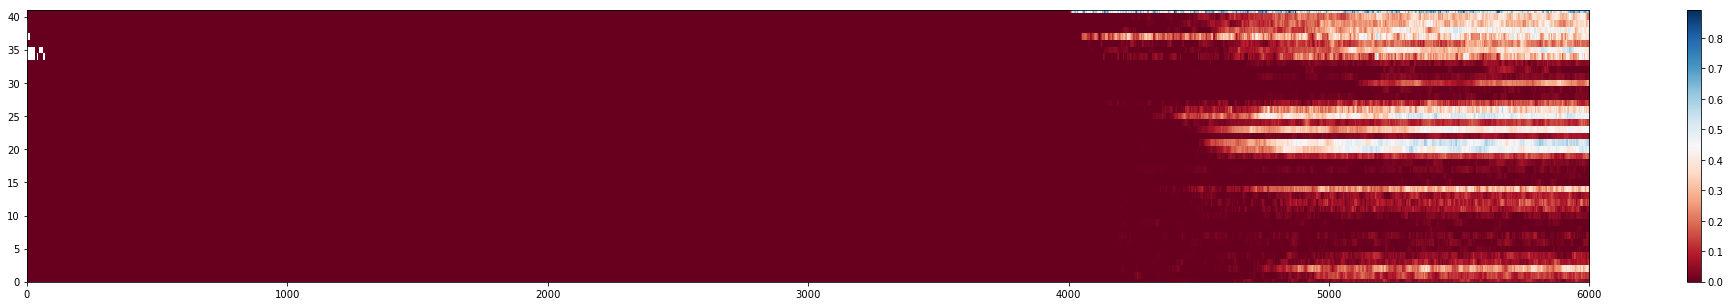

In [380]:
ratio = one_model.mis_history / (one_model.mis_history + one_model.nor_history)
plt.figure(figsize = (35, 5))
plt.imshow(ratio.T,  cmap=plt.cm.RdBu, aspect='auto')
plt.xlim(0, 6000)
plt.ylim(0, 41)
plt.colorbar()
plt.show()

In [41]:
snca

array([[ 0.59934275],
       [ 0.26101632],
       [ 0.29000476],
       [ 0.82548406],
       [ 0.64681165],
       [ 0.46708861],
       [ 0.39060002],
       [ 0.540445  ],
       [ 0.23598362],
       [ 0.07745063],
       [ 0.16678801],
       [ 1.09441929],
       [ 0.5493068 ],
       [ 0.61300713],
       [ 0.39203754],
       [ 0.12267327],
       [ 0.47482925],
       [ 0.11458936],
       [ 0.33640297],
       [ 0.07466711],
       [-0.37034188],
       [-0.94981583],
       [-0.19041772],
       [-0.30001395],
       [ 0.74709943],
       [ 0.44602376],
       [ 0.43051001],
       [ 0.75563896],
       [ 0.62976586],
       [ 0.65549983],
       [ 0.36909722],
       [ 0.64775809],
       [ 0.28991633],
       [ 0.77699072],
       [-3.33599077],
       [-2.04487788],
       [-2.00433353],
       [-2.77105086],
       [-1.67836188],
       [-0.47255766],
       [-0.79877398],
       [ 0.89528759]])

In [28]:
print(ref_model.weights[:, 0])

[  5.00000000e-01   1.09868721e-01   0.00000000e+00   0.00000000e+00
   3.36497591e-02   0.00000000e+00   1.95975993e-02   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.36619557e-03   0.00000000e+00   3.11679657e-04
   4.11281586e-04   6.01634015e-03   9.77070167e-03   7.71687431e-03
   1.31527236e-03   0.00000000e+00   1.53863229e-03   2.12806671e-02
   0.00000000e+00   0.00000000e+00   0.00000000e+00   2.85076141e-02
   0.00000000e+00   4.01616247e-02   2.05182233e-03   1.54469524e-02
   1.85345943e-02   0.00000000e+00   4.74075350e-03   0.00000000e+00
   3.45647835e-03   0.00000000e+00]


In [615]:
for t in range(600):
    ref_model.record_to_history()
    ref_model.nor_step_region()
    ref_model.nor_travel()

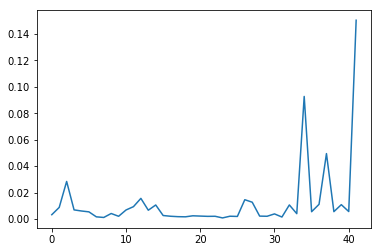

0.17210000123132613

In [681]:
plt.plot(np.arange(42), (1  - np.exp(- 7 / ref_model.nor)  ) )
#plt.plot(np.arange(42), ref_model.clearance_rate)
plt.show()
#np.max((1  - np.exp(- 1 / roi_size.flatten())  )* ref_model.nor*ref_model.clearance_rate)

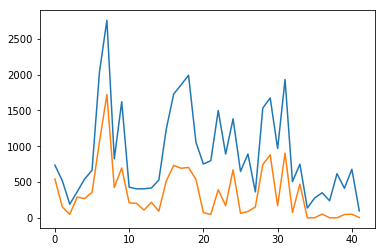

In [264]:
plt.plot(np.arange(42), ref_model.nor_history[599,:])
plt.plot(np.arange(42), ref_model.synthesis_rate * ref_model.roi_size)
plt.show()

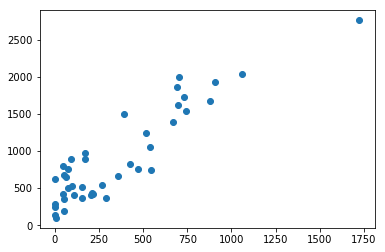

In [267]:
plt.plot(ref_model.synthesis_rate * ref_model.roi_size, ref_model.nor_history[599,:], marker = 'o', ls='')
plt.show()

In [36]:
print(norm.cdf(snca)/norm.cdf(gba))

[[  1.15690787e+00]
 [  1.14086174e+00]
 [  1.04870543e+00]
 [  1.02317342e+00]
 [  1.08578554e+00]
 [  8.76823156e-01]
 [  1.03842504e+00]
 [  8.90289158e-01]
 [  8.24914831e-01]
 [  1.11276006e+00]
 [  1.10043645e+00]
 [  1.01179406e+00]
 [  7.98874928e-01]
 [  1.29209067e+00]
 [  8.29381671e-01]
 [  1.21210413e+00]
 [  1.30687472e+00]
 [  1.38135591e+00]
 [  1.63923477e+00]
 [  1.29877197e+00]
 [  3.42789499e+00]
 [  3.68423636e+00]
 [  1.70766039e+00]
 [  8.72928303e+01]
 [  1.58000031e+00]
 [  1.26533207e+01]
 [  8.43128091e-01]
 [  9.16965475e-01]
 [  1.21504867e+00]
 [  1.08199065e+00]
 [  2.29606920e+00]
 [  1.64092023e+00]
 [  1.04559176e+00]
 [  1.02064491e+00]
 [  9.98085575e-04]
 [  3.50647031e-01]
 [  2.92358202e-01]
 [  2.47413856e-02]
 [  2.96755626e-01]
 [  4.20820030e-01]
 [  1.84835973e+00]
 [  5.17483578e-01]]


In [143]:
ref_model.nor

array([ 879,  694,  416,  632,  823,  992, 1765, 1886, 1139, 1474,  678,
        668,  701,  742,  802, 1443, 1949, 1670, 2181, 1027,  791,  937,
       1642, 1066, 1427,  865,  937,  705, 1806, 1835, 1568, 1669,  974,
       1014,  560,  791,  877,  612,  779,  816,  856,  331])

In [415]:
one_model.prob_infected

array([ 0.06729488,  0.35529803,  0.73324605,  0.12097314,  0.10151572,
        0.0747023 ,  0.00809712,  0.00237094,  0.00564572,  0.0325992 ,
        0.05016841,  0.21395461,  0.33173931,  0.1171316 ,  0.54338196,
        0.06897323,  0.08649545,  0.13763325,  0.27509847,  0.08605413,
        0.61562643,  0.78802396,  0.30775552,  0.41351404,  0.12158858,
        0.78483114,  0.91990887,  0.38547827,  0.05023546,  0.03751977,
        0.73245257,  0.14613648,  0.61959819,  0.05754343,  0.04443696,
        0.19889937,  0.12269019,  0.33397811,  0.79225181,  0.25627427,
        0.63212056,  0.96491565])

In [30]:
from scipy.io import loadmat
para2 = loadmat('/dagher/dagher6/yzheng/ICBM152_nlin_sym_09a/simulator_v3/workspace.mat')
nsconn_den = para2['nsconnDen_th']
np.sum(nsconn_den, axis = 1).shape
weights = nsconn_den / np.sum(nsconn_den, axis = 0)[np.newaxis]
print(np.sum(weights, axis = 0))

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.]


/export02/data/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


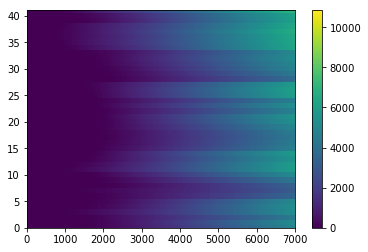

In [719]:
ratio = one_model.mis_history / (one_model.mis_history + one_model.nor_history)
plt.imshow(ratio_cum.T, aspect='auto')
plt.xlim(0, 7000)
plt.ylim(0, 41)
plt.colorbar()
plt.show()

In [718]:
weights = nsconn_den / np.sum(nsconn_den, axis = 0)[np.newaxis]
ratio_th = ratio.copy()
ratio_th[ratio<0] = 0
ratio_cum = np.dot( (1 - np.exp(-ratio_th)), weights)
ratio_cum = ratio_cum + 1-np.exp(-ratio_th)
ratio_cum = np.cumsum(ratio_cum[3000:], axis = 0)
(r, p) = pearsonr(ratio[-1, :-1], real_atrophy.flatten())
r

/export02/data/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


0.33226946305995808

In [325]:
plt.plot

array([[ 1.        ,  0.47877552],
       [ 0.47877552,  1.        ]])

In [326]:
r

0.48432958286706079

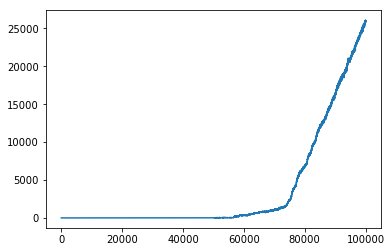

In [762]:
plt.plot(np.arange(one_model.mis_history.shape[0]), one_model.mis_history[:, 41])
plt.show()

In [149]:
ref_model.nor

array([ 98,  81,  50,  63,  84,  96, 166, 202,  93, 140,  76,  64,  66,
        80,  76, 149, 186, 173, 198,  98,  86, 112, 169, 118, 148,  73,
        98,  72, 186, 181, 161, 209,  95,  98,  63,  77,  91,  76,  74,
        74,  84,  78])

In [168]:
np.nonzero(sconn_len[41])

(array([ 4,  6,  7,  9, 34, 35, 36, 37]),)

In [169]:
sconn_len[41, np.nonzero(sconn_len[41])]

array([[ 165.14837153,  168.49995681,  167.82605699,  151.36596958,
          17.91637478,   74.84649271,   72.02182617,   32.24336325]])

In [273]:
r = np.zeros((42, 100))
for region in np.arange(42):
    """iterate through regions to find epicentre"""
    for simulation in np.arange(100):
        one_model = copy.deepcopy(ref_model)
        one_model.inject_mis(41, 1)
        for t in range(2000):
            one_model.record_to_history()
            one_model.transmission_region()
            one_model.nor_travel()
            one_model.mis_travel()
        
        ratio = one_model.mis_history / (one_model.mis_history + one_model.nor_history)
        ratio_th = ratio.copy()
        ratio_th[ratio<0.2] = 0
        ratio_cum = np.dot( (1 - np.exp(-ratio_th)), weights)
        ratio_cum = ratio_cum + 1-np.exp(-ratio_th)
        ratio_cum = np.cumsum(ratio_cum[600:], axis = 0)
        (r[region, simulation], p) = pearsonr(ratio_cum[-1, :-1], real_atrophy.flatten())
        if r[region,simulation] == np.nan:
            r[region, simulation] = 0

/export02/data/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in true_divide
/export02/data/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less
/export02/data/anaconda/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3029: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [281]:
r[np.isnan(r)] = 0

In [283]:
mean_r = np.mean(r, axis = 1)

In [298]:
sconn = loadmat('/dagher/dagher6/yzheng/ICBM152_nlin_sym_09a/sconn0712.mat')
sconn_len = sconn['sconnLen_expand']
sconn_den = sconn['sconnDen_expand']

In [45]:
print(one_model.mis_history[:, 41])

[   0    0    0 ..., 3082 3053 3070]


In [99]:
print(ref_model.synthesis_rate * roi_size.flatten())

[  8.71045629e+01   2.44279151e+01   8.07609215e+00   4.67646055e+01
   4.31845838e+01   5.71520132e+01   1.69668704e+02   2.75811527e+02
   6.80735200e+01   1.11660786e+02   3.36038559e+01   3.25342214e+01
   1.75935082e+01   3.48760295e+01   1.51401900e+01   8.25698423e+01
   1.17402206e+02   1.10985553e+02   1.12762813e+02   8.58580759e+01
   1.18964971e+01   7.71937333e+00   6.30244032e+01   2.75063723e+01
   1.07455136e+02   1.03872478e+01   1.44369335e+01   2.45134048e+01
   1.19056923e+02   1.40863963e+02   2.71009788e+01   1.45001612e+02
   1.20936880e+01   7.54361074e+01   6.59048287e-02   4.97597493e-01
   8.62870038e+00   3.75899533e-01   2.40217690e-01   7.66946222e+00
   8.40637415e+00   8.08588838e-01]


In [122]:
np.ones((3, ), dtype = np.int) * 0.01

array([ 0.01,  0.01,  0.01])

In [124]:
np.array([k for k in range(4)]) * 0.1

array([ 0. ,  0.1,  0.2,  0.3])